In [ ]:
!git clone https://github.com/Anju212000/COPD-MSC-project.git

Cloning into 'COPD-MSC-project'...
remote: Enumerating objects: 43682, done.
remote: Total 43682 (delta 0), reused 0 (delta 0), pack-reused 43682 (from 1)
Receiving objects: 100% (43682/43682), 355.90 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (5165/5165), done.
Updating files: 100% (43676/43676), done.


In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 108.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
# Import libraries
import pandas as pd
import wfdb
import os
import numpy as np
import ast
from tqdm import tqdm
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.signal import find_peaks, welch
from scipy.fft import fft
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.signal import find_peaks, welch
from scipy.integrate import trapezoid
from scipy.signal import find_peaks, welch
from scipy.integrate import trapezoid
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import wfdb
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# --- Setup Paths ---
BASE_DIR = '/content/COPD-MSC-project/dataset'
CSV_PATH = os.path.join(BASE_DIR, '/content/COPD-MSC-project/dataset/ptbxl_database.csv')
RECORDS_DIR = os.path.join(BASE_DIR, '/content/COPD-MSC-project/dataset/records100')
SCP_PATH = os.path.join(BASE_DIR, '/content/COPD-MSC-project/dataset/scp_statements.csv')

In [ ]:
# --- Load Metadata and Diagnostic Mappings ---
print("Loading metadata and diagnostic mappings...")
df = pd.read_csv(CSV_PATH)

df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
scp_df = pd.read_csv(SCP_PATH)
diagnostic_codes = scp_df[scp_df['diagnostic'] == 1].iloc[:, 0].values

Loading metadata and diagnostic mappings...


In [ ]:
diagnostic_codes

array(['NDT', 'NST_', 'DIG', 'LNGQT', 'NORM', 'IMI', 'ASMI', 'LVH',
       'LAFB', 'ISC_', 'IRBBB', '1AVB', 'IVCD', 'ISCAL', 'CRBBB', 'CLBBB',
       'ILMI', 'LAO/LAE', 'AMI', 'ALMI', 'ISCIN', 'INJAS', 'LMI', 'ISCIL',
       'LPFB', 'ISCAS', 'INJAL', 'ISCLA', 'RVH', 'ANEUR', 'RAO/RAE', 'EL',
       'WPW', 'ILBBB', 'IPLMI', 'ISCAN', 'IPMI', 'SEHYP', 'INJIN',
       'INJLA', 'PMI', '3AVB', 'INJIL', '2AVB'], dtype=object)

In [ ]:
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21837 entries, 0 to 21836
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        21837 non-null  int64  
 1   patient_id                    21837 non-null  float64
 2   age                           21748 non-null  float64
 3   sex                           21837 non-null  int64  
 4   height                        6983 non-null   float64
 5   weight                        9429 non-null   float64
 6   nurse                         20328 non-null  float64
 7   site                          21819 non-null  float64
 8   device                        21837 non-null  object 
 9   recording_date                21837 non-null  object 
 10  report                        21837 non-null  object 
 11  scp_codes                     21837 non-null  object 
 12  heart_axis                    13332 non-null  object 
 13  i

In [ ]:
df.describe()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,validated_by,strat_fold
count,21837.00000,21837.000000,21748.000000,21837.000000,6983.000000,9429.000000,20328.000000,21819.000000,12426.000000,21837.000000
mean,10919.00000,11255.005953,59.836307,0.478912,166.708292,70.997561,2.292503,1.547229,0.747948,5.505335
std,6303.94325,6234.132489,16.953125,0.499567,10.864935,15.875146,3.254786,4.169753,1.183269,2.875306
min,1.00000,302.000000,2.000000,0.000000,6.000000,5.000000,0.000000,0.000000,0.000000,1.000000
25%,5460.00000,5982.000000,50.000000,0.000000,160.000000,60.000000,0.000000,0.000000,0.000000,3.000000
50%,10919.00000,11423.000000,62.000000,0.000000,166.000000,70.000000,1.000000,1.000000,1.000000,6.000000
75%,16378.00000,16614.000000,72.000000,1.000000,174.000000,80.000000,3.000000,2.000000,1.000000,8.000000
max,21837.00000,21797.000000,95.000000,1.000000,209.000000,250.000000,11.000000,50.000000,11.000000,10.000000


<Figure size 1200x800 with 0 Axes>

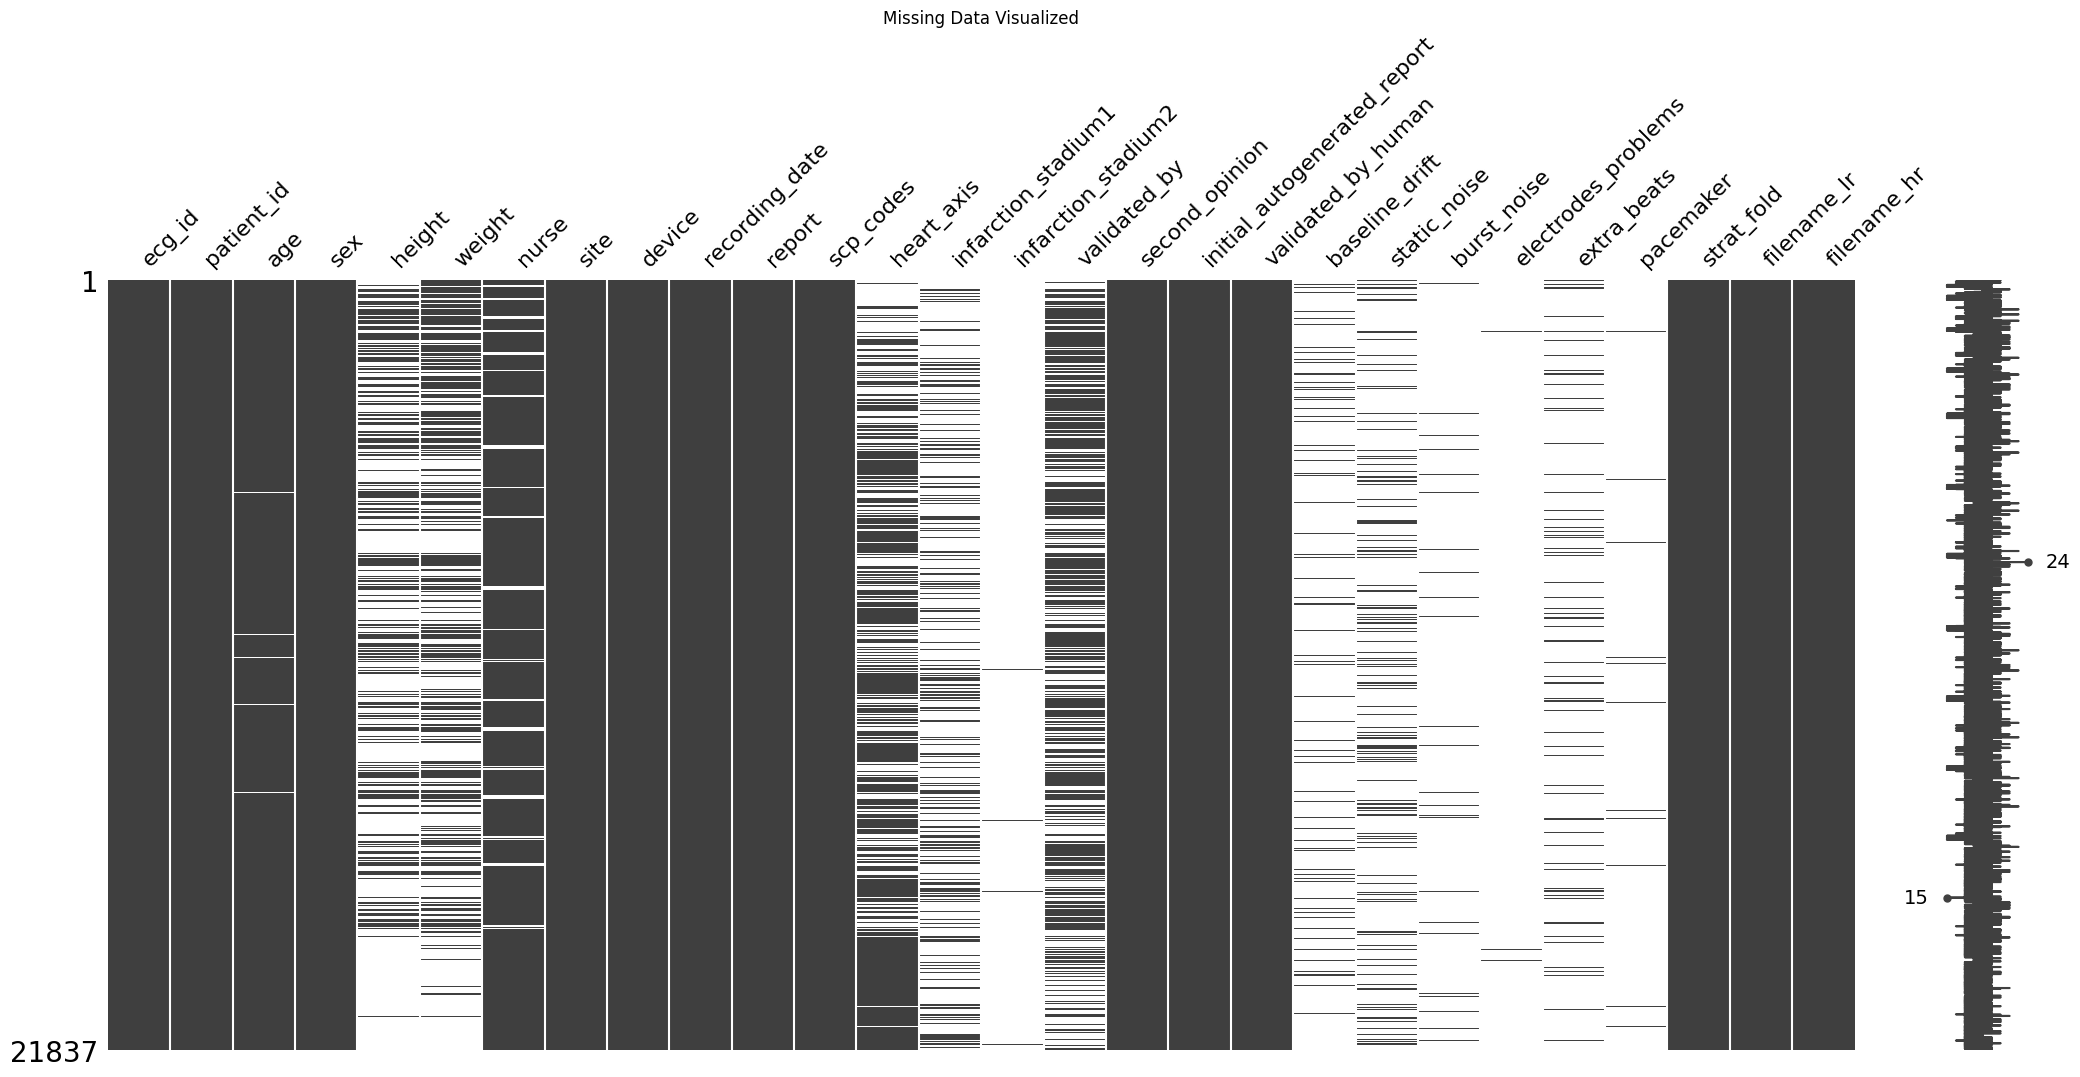

Missing values per column:
ecg_id                              0
patient_id                          0
age                                89
sex                                 0
height                          14854
weight                          12408
nurse                            1509
site                               18
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8505
infarction_stadium1             16211
infarction_stadium2             21734
validated_by                     9411
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20230
static_noise                    18575
burst_noise                     21224
electrodes_problems             21807
extra_beats                     19883
pacemaker                       21544
strat_fold             

In [ ]:
# Explore missing data
plt.figure(figsize=(12, 8))
msno.matrix(df)
plt.title('Missing Data Visualized')
plt.show()

# Summary of missing data per column
print("Missing values per column:")
print(df.isna().sum())

In [ ]:
scp_df.head()

,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
0,NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
1,NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
2,DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
3,LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
4,NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [ ]:
scp_df.head()

,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
0,NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
1,NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
2,DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
3,LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
4,NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [ ]:
scp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     71 non-null     object 
 1   description                    71 non-null     object 
 2   diagnostic                     44 non-null     float64
 3   form                           19 non-null     float64
 4   rhythm                         12 non-null     float64
 5   diagnostic_class               44 non-null     object 
 6   diagnostic_subclass            44 non-null     object 
 7   Statement Category             71 non-null     object 
 8   SCP-ECG Statement Description  71 non-null     object 
 9   AHA code                       37 non-null     float64
 10  aECG REFID                     23 non-null     object 
 11  CDISC Code                     13 non-null     object 
 12  DICOM Code                     13 non-null     objec

In [ ]:
scp_df.describe()

,diagnostic,form,rhythm,AHA code
count,44.0,19.0,12.0,37.000000
mean,1.0,1.0,1.0,144.297297
std,0.0,0.0,0.0,119.739037
min,1.0,1.0,1.0,1.000000
25%,1.0,1.0,1.0,60.000000
50%,1.0,1.0,1.0,140.000000
75%,1.0,1.0,1.0,162.000000
max,1.0,1.0,1.0,502.000000


<Figure size 1200x800 with 0 Axes>

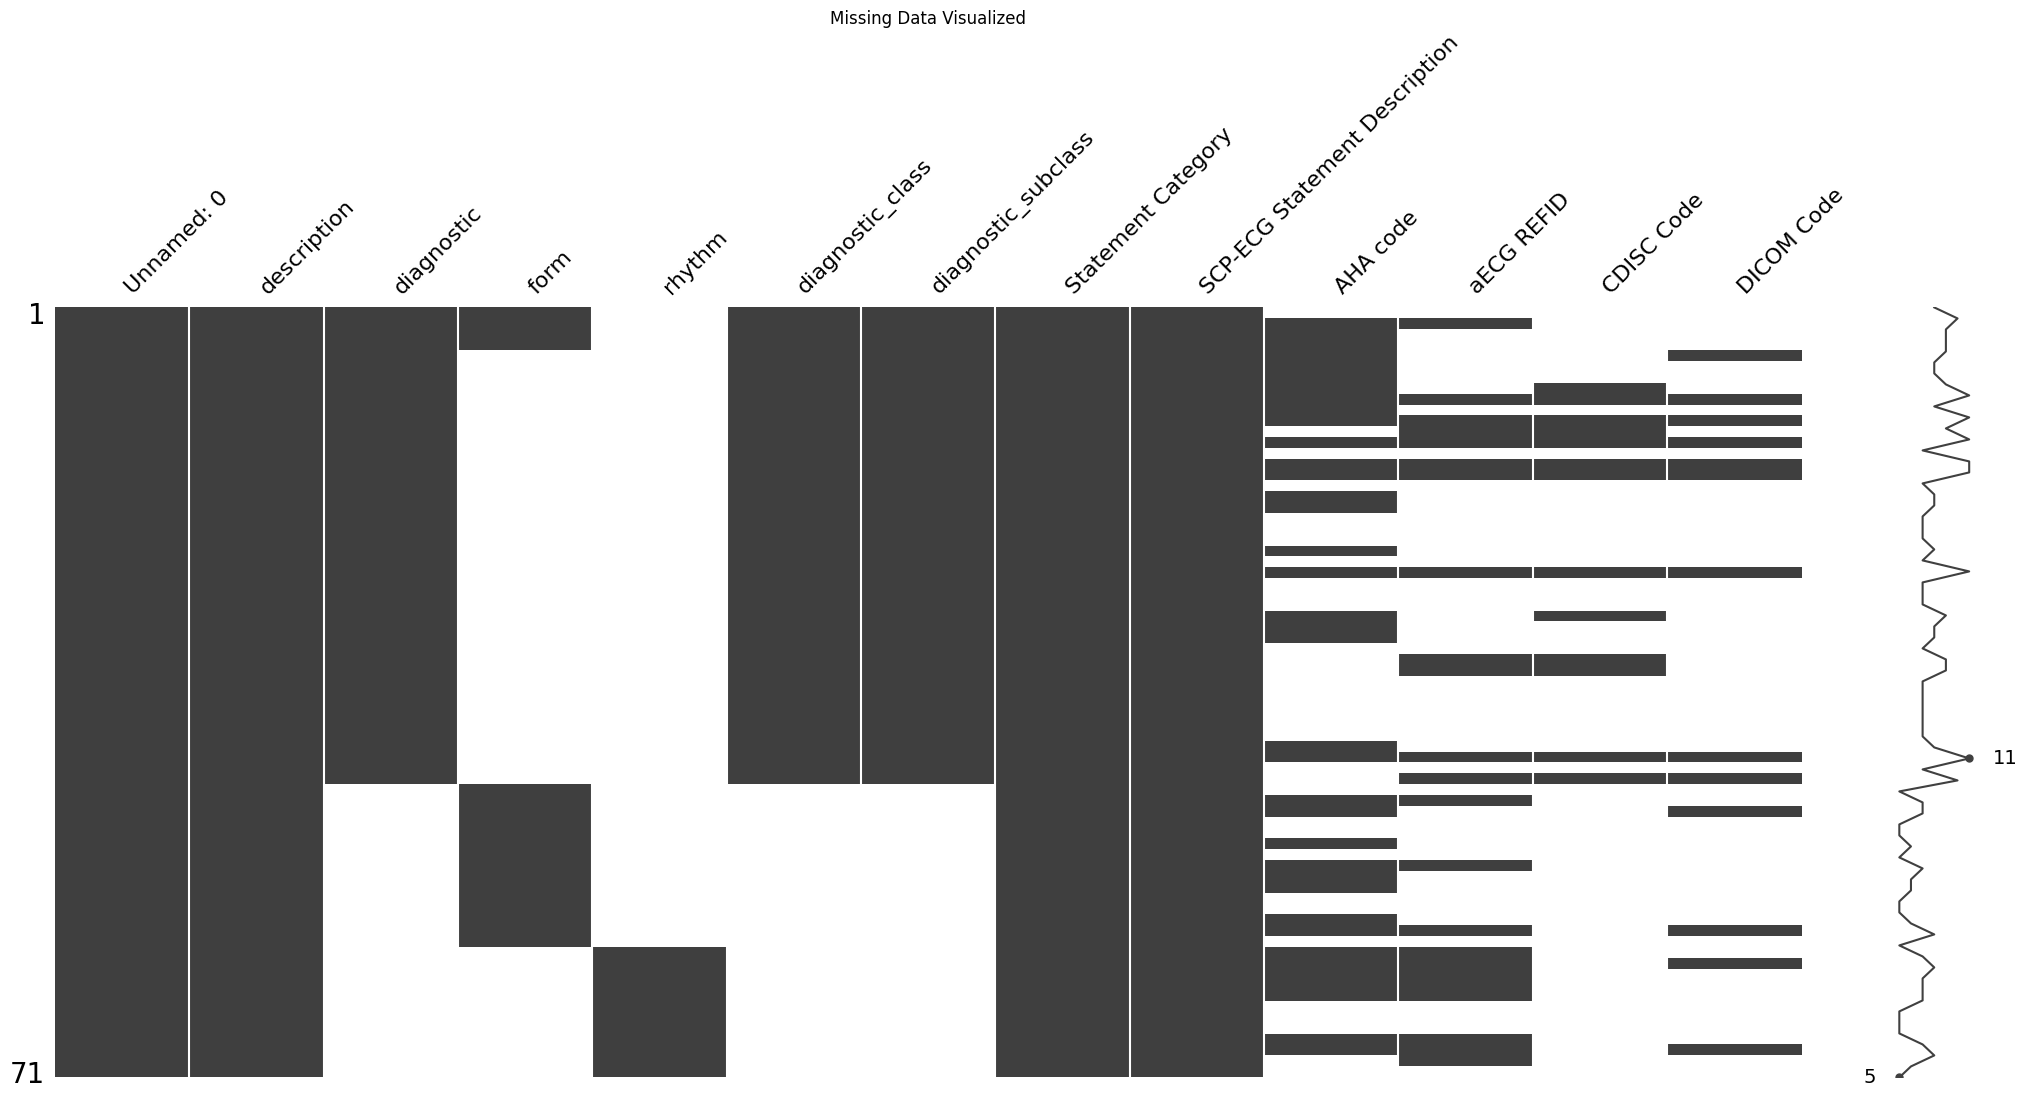

Missing values per column:
Unnamed: 0                        0
description                       0
diagnostic                       27
form                             52
rhythm                           59
diagnostic_class                 27
diagnostic_subclass              27
Statement Category                0
SCP-ECG Statement Description     0
AHA code                         34
aECG REFID                       48
CDISC Code                       58
DICOM Code                       58
dtype: int64


In [ ]:
# Explore missing data
plt.figure(figsize=(12, 8))
msno.matrix(scp_df)
plt.title('Missing Data Visualized')
plt.show()

# Summary of missing data per column
print("Missing values per column:")
print(scp_df.isna().sum())

In [ ]:
# --- Extract Diagnostic Labels and Super/Subclasses ---
def extract_labels(code_dict):
    return [code for code in code_dict if code in diagnostic_codes]

df['diagnostic_label'] = df['scp_codes'].apply(extract_labels)
df = df[df['diagnostic_label'].map(len) > 0]  # Filter rows with valid labels
df['target'] = df['diagnostic_label'].apply(lambda x: x[0] if x else 'Unknown')  # Ensure target is set

# Map SCP codes to superclasses and subclasses (assuming diagnostic_class and diagnostic_subclass exist)
scp_superclass = dict(zip(scp_df.iloc[:, 0], scp_df['diagnostic_class'].fillna('Unknown')))
scp_subclass = dict(zip(scp_df.iloc[:, 0], scp_df['diagnostic_subclass'].fillna('Unknown')))
df['superclass'] = df['scp_codes'].apply(lambda x: [scp_superclass.get(code, 'Unknown') for code in x])
df['subclass'] = df['scp_codes'].apply(lambda x: [scp_subclass.get(code, 'Unknown') for code in x])
df['superclass'] = df['superclass'].apply(lambda x: x[0] if x else 'Unknown')
df['subclass'] = df['subclass'].apply(lambda x: x[0] if x else 'Unknown')

# --- Select Relevant Columns ---
columns_to_use = ['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
                  'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
                  'infarction_stadium1', 'infarction_stadium2', 'validated_by',
                  'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
                  'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
                  'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr', 'target']
df = df[columns_to_use + ['superclass', 'subclass']]

# --- Handle Null Values ---
df['age'] = pd.to_numeric(df['age'], errors='coerce').fillna(df['age'].median())
df['sex'] = df['sex'].map({0: 'Male', 1: 'Female'}).fillna('Male')
df['height'] = pd.to_numeric(df['height'], errors='coerce').apply(lambda x: np.nan if x < 50 else x).fillna(df['height'].median())
df['weight'] = pd.to_numeric(df['weight'], errors='coerce').fillna(df['weight'].median())
df['nurse'] = df['nurse'].fillna('Unknown')
df['site'] = df['site'].fillna('Unknown')
df['device'] = df['device'].fillna('Unknown')
df['recording_date'] = pd.to_datetime(df['recording_date'], errors='coerce').fillna(pd.Timestamp('2000-01-01'))
df['validated_by'] = df['validated_by'].fillna('Unknown')
df['second_opinion'] = df['second_opinion'].fillna(False).astype(bool)
df['initial_autogenerated_report'] = df['initial_autogenerated_report'].fillna(False).astype(bool)
df['validated_by_human'] = df['validated_by_human'].fillna(False).astype(bool)
for noise_col in ['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats']:
    df[noise_col] = df[noise_col].fillna(False).astype(bool)
df['pacemaker'] = df['pacemaker'].fillna(False).astype(bool)
df['strat_fold'] = pd.to_numeric(df['strat_fold'], errors='coerce').fillna(0).astype(int)  # Ensure integer
df['infarction_stadium2'] = df['infarction_stadium2'].fillna('unknown')

In [ ]:
# --- Load ECG Signals (First 50 Patients) ---
ecg_data = []
valid_indices = []
print("Loading ECG signals from records100 for the first 50 patients...")
for idx, row in tqdm(df[:50].iterrows(), total=50, desc="Loading ECGs"):
    # Use BASE_DIR and filename_lr directly
    full_path = os.path.join(BASE_DIR, row['filename_lr']).replace('.dat', '')
    if os.path.exists(full_path + '.dat') and os.path.exists(full_path + '.hea'):
        try:
            signal, _ = wfdb.rdsamp(full_path)
            ecg_data.append(signal)
            valid_indices.append(idx)
        except Exception as e:
            print(f"Error loading {full_path}: {e}")
    else:
        print(f"Files not found: {full_path}.dat or {full_path}.hea")

if not ecg_data:
    raise ValueError("No ECG signals loaded. Check dataset path or filename_lr consistency.")

Loading ECG signals from records100 for the first 50 patients...


Loading ECGs: 100%|██████████| 50/50 [00:00<00:00, 88.98it/s]


In [ ]:
# --- Pad/Truncate ECG Signals ---
max_len = 5000
processed_ecg = []
for sig in ecg_data:
    if sig.shape[0] >= max_len:
        processed_ecg.append(sig[:max_len, :])
    else:
        pad = np.zeros((max_len - sig.shape[0], sig.shape[1]))
        processed_ecg.append(np.vstack([sig, pad]))

ecg_array = np.array(processed_ecg, dtype=np.float32)
print(f"ECG array shape: {ecg_array.shape}")

# --- Filter DataFrame ---
df_valid = df.loc[valid_indices].reset_index(drop=True)
print("Columns in df_valid:", df_valid.columns.tolist())

ECG array shape: (50, 5000, 12)
Columns in df_valid: ['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr', 'target', 'superclass', 'subclass']


In [ ]:
# --- Feature Engineering on ECG Signals ---
fs = 100  # Sampling frequency (Hz)
ecg_features = []
for i in range(ecg_array.shape[0]):
    lead_I = ecg_array[i, :, 0]  # Lead I for reference
    # Detect peaks across all leads
    all_peaks = [find_peaks(ecg_array[i, :, j], height=np.mean(ecg_array[i, :, j]), distance=50)[0] for j in range(12)]
    peaks = all_peaks[0] if all_peaks[0].size > 0 else np.array([])
    rr_intervals = np.diff(peaks) / fs if len(peaks) > 1 else [np.nan]
    heart_rate = 60 / np.nanmean(rr_intervals) if len(rr_intervals) > 0 else np.nan
    qrs_duration = np.nanmean([len(np.where(np.abs(ecg_array[i, p-10:p+10, 0]) > 0.1)[0]) / fs
                              for p in peaks]) if len(peaks) > 0 else np.nan
    mean_amplitude = np.mean(ecg_array[i, :, 0])
    std_amplitude = np.std(ecg_array[i, :, 0])

    # ST Segment Deviation (approximate across leads)
    st_start = int(0.4 * fs)
    st_end = int(0.6 * fs)
    st_deviation = np.mean([np.mean(ecg_array[i, st_start:st_end, j]) - np.mean(ecg_array[i, :st_start, j])
                           for j in range(12)]) if len(ecg_array[i]) > st_end else np.nan

    # T-Wave Amplitude (approximate peak after QRS)
    t_wave_idx = [p + int(0.3 * fs) for p in peaks if p + int(0.3 * fs) < len(lead_I)]
    t_amplitude = np.max([np.max(ecg_array[i, t_wave_idx, j]) for j in range(12)]) if t_wave_idx else np.nan

    # PSD Bands
    f, psd = welch(lead_I, fs=fs, nperseg=256)
    low_freq_power = np.trapz(psd[(f >= 0) & (f <= 4)], f[(f >= 0) & (f <= 4)]) if len(f) > 0 else np.nan
    high_freq_power = np.trapz(psd[(f > 4) & (f <= 40)], f[(f > 4) & (f <= 40)]) if len(f) > 0 else np.nan

    ecg_features.append({
        'heart_rate': heart_rate,
        'qrs_duration': qrs_duration,
        'mean_amplitude': mean_amplitude,
        'std_amplitude': std_amplitude,
        'st_deviation': st_deviation,
        't_amplitude': t_amplitude,
        'low_freq_power': low_freq_power,
        'high_freq_power': high_freq_power
    })
ecg_features_df = pd.DataFrame(ecg_features)
ecg_features_df.fillna(ecg_features_df.median(), inplace=True)

In [ ]:
# --- Combine Data ---
X_demo = pd.concat([df_valid, ecg_features_df], axis=1)
y = df_valid['target']  # Should now work if 'target' is present

In [ ]:
X_demo = X_demo.drop(['ecg_id', 'patient_id', 'filename_lr', 'filename_hr', 'heart_axis',
                      'infarction_stadium1', 'infarction_stadium2', 'scp_codes', 'report'], axis=1)

In [ ]:
# --- Prepare Data for Visualization ---
df_plot = X_demo.copy()
for col in ['age', 'height', 'weight', 'heart_rate', 'qrs_duration', 'mean_amplitude',
            'std_amplitude', 'st_deviation', 't_amplitude', 'low_freq_power', 'high_freq_power']:
    df_plot[col] = pd.to_numeric(df_plot[col], errors='coerce').fillna(df_plot[col].median())

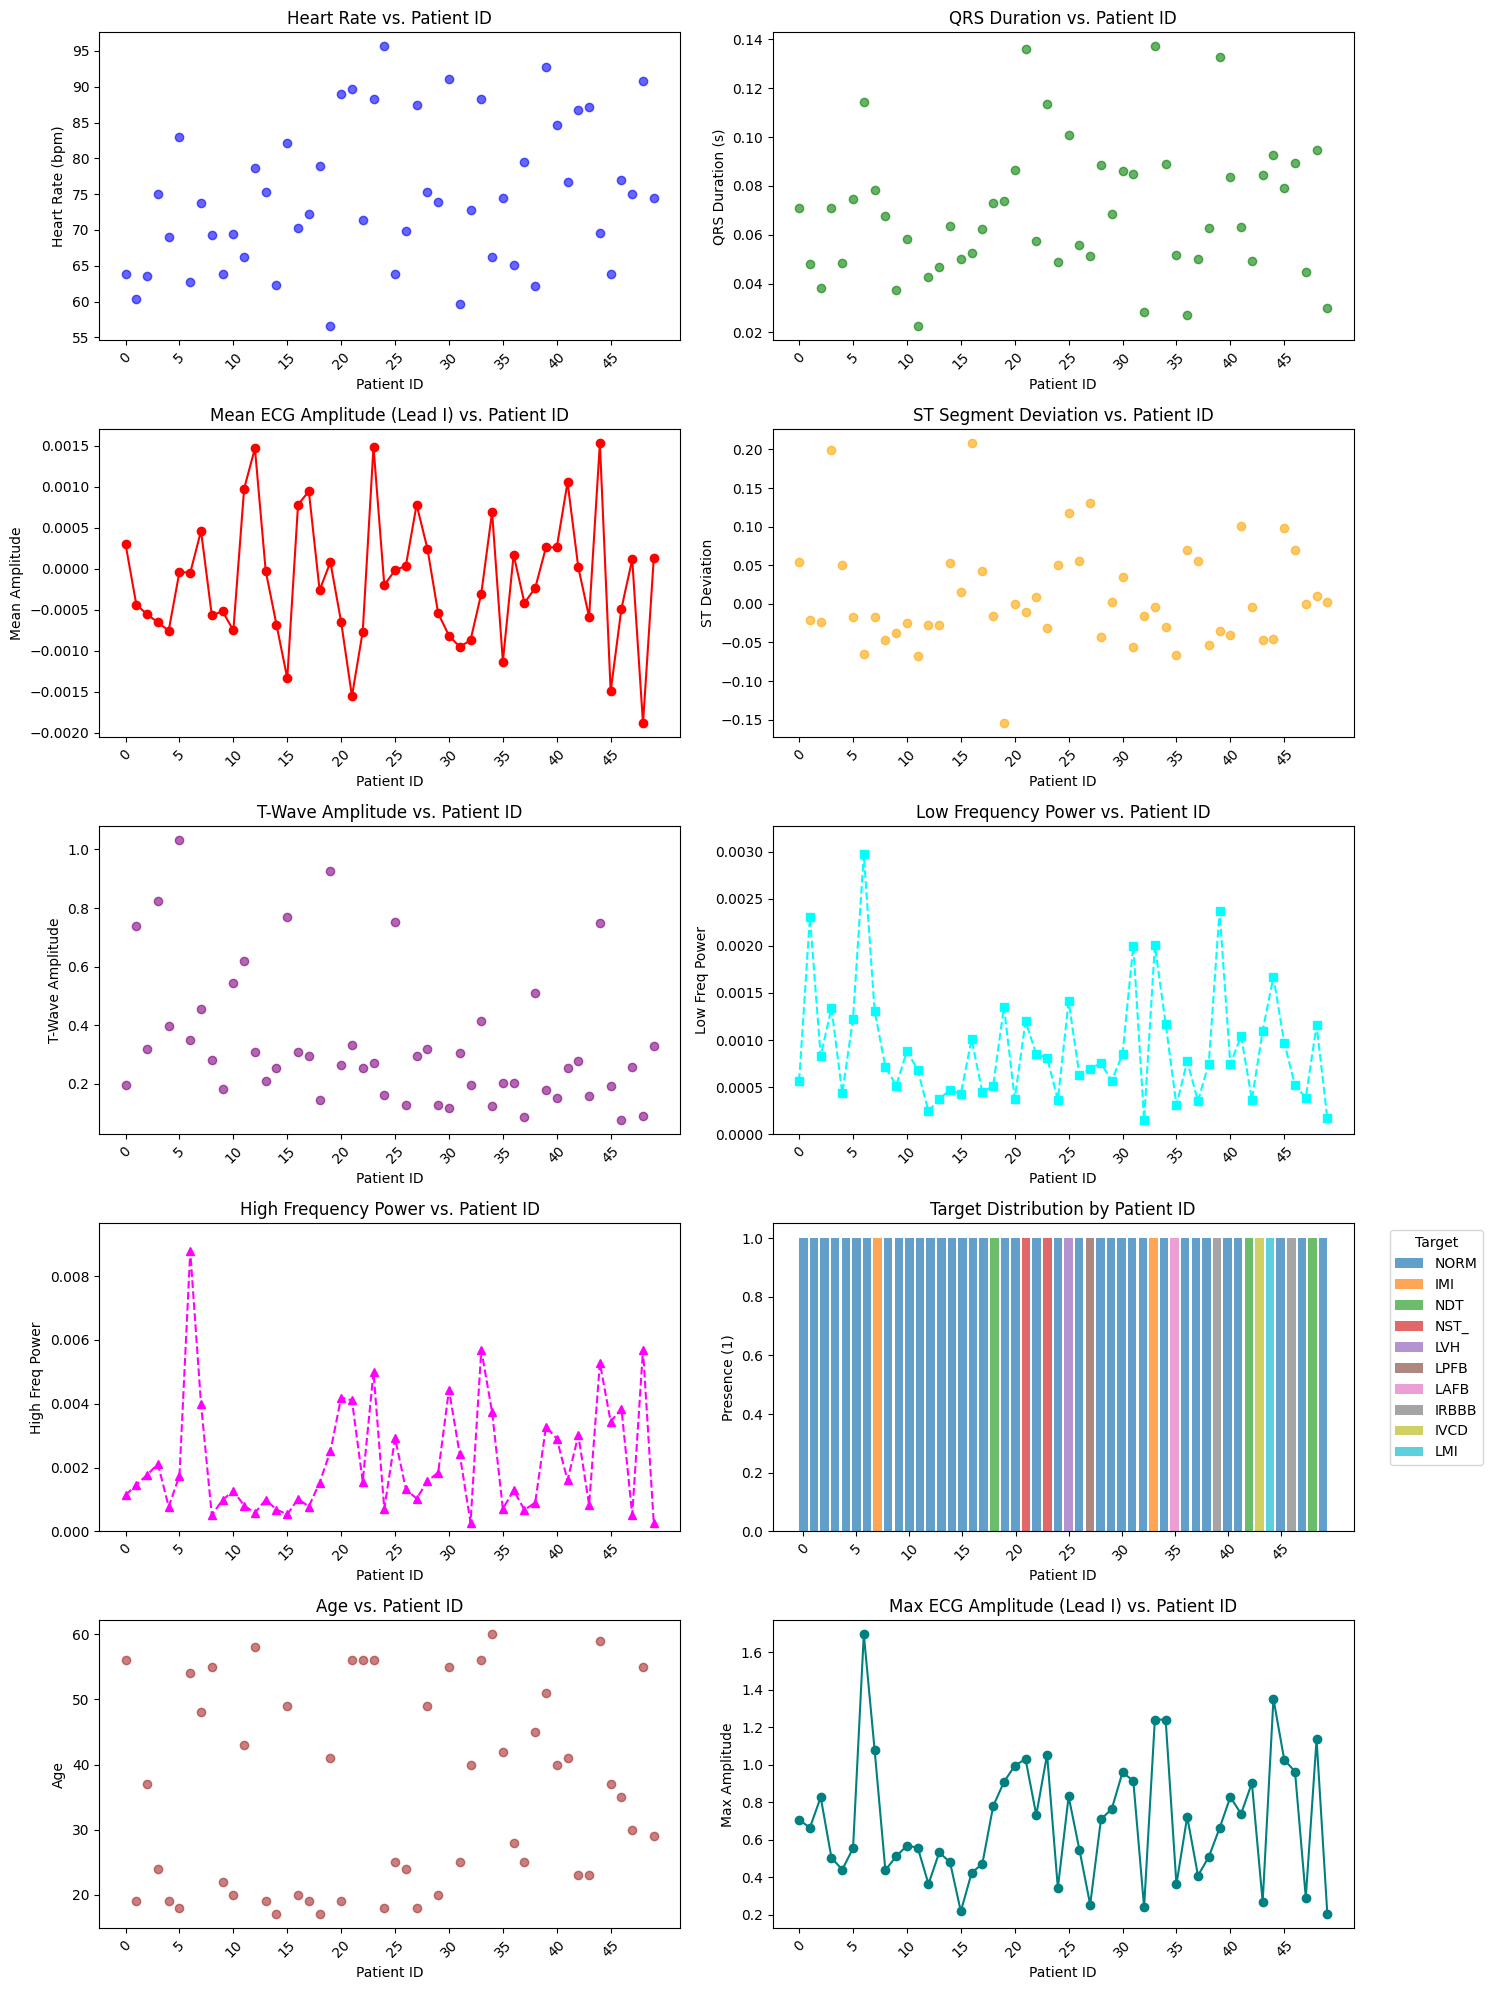

In [ ]:
# --- Patient-Level Visualizations ---
plt.figure(figsize=(15, 20))  # Adjusted for 5x2 grid

# Ensure patient_id is usable
patient_ids = df_valid['patient_id']
if not np.issubdtype(patient_ids.dtype, np.number) or len(set(patient_ids)) != len(patient_ids):
    print("Warning: patient_id contains non-numeric or duplicate values. Using range(0, 50) instead.")
    patient_ids = np.arange(len(df_valid))  # Use numpy array for indexing
else:
    patient_ids = pd.to_numeric(patient_ids, errors='coerce').fillna(-1).astype(int)  # Convert to numeric

# 1. Heart Rate vs. Patient ID (Scatter Plot)
plt.subplot(5, 2, 1)
plt.scatter(patient_ids, ecg_features_df['heart_rate'], c='blue', alpha=0.6)
plt.title('Heart Rate vs. Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('Heart Rate (bpm)')
plt.xticks(patient_ids[::5], rotation=45)

# 2. QRS Duration vs. Patient ID (Scatter Plot)
plt.subplot(5, 2, 2)
plt.scatter(patient_ids, ecg_features_df['qrs_duration'], c='green', alpha=0.6)
plt.title('QRS Duration vs. Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('QRS Duration (s)')
plt.xticks(patient_ids[::5], rotation=45)

# 3. Mean ECG Amplitude vs. Patient ID (Lead I, Line Plot)
plt.subplot(5, 2, 3)
mean_amplitude = np.mean(ecg_array[:, :, 0], axis=1)
plt.plot(patient_ids, mean_amplitude, marker='o', linestyle='-', color='red')
plt.title('Mean ECG Amplitude (Lead I) vs. Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('Mean Amplitude')
plt.xticks(patient_ids[::5], rotation=45)

# 4. ST Segment Deviation vs. Patient ID (Scatter Plot)
plt.subplot(5, 2, 4)
st_dev = ecg_features_df['st_deviation'].fillna(0)
plt.scatter(patient_ids, st_dev, c='orange', alpha=0.6)
plt.title('ST Segment Deviation vs. Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('ST Deviation')
plt.xticks(patient_ids[::5], rotation=45)

# 5. T-Wave Amplitude vs. Patient ID (Scatter Plot)
plt.subplot(5, 2, 5)
plt.scatter(patient_ids, ecg_features_df['t_amplitude'], c='purple', alpha=0.6)
plt.title('T-Wave Amplitude vs. Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('T-Wave Amplitude')
plt.xticks(patient_ids[::5], rotation=45)

# 6. Low Frequency Power vs. Patient ID (Line Plot with Scaling)
plt.subplot(5, 2, 6)
low_freq = ecg_features_df['low_freq_power'].fillna(0)
plt.plot(patient_ids, low_freq, marker='s', linestyle='--', color='cyan')
plt.title('Low Frequency Power vs. Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('Low Freq Power')
plt.xticks(patient_ids[::5], rotation=45)
plt.ylim(0, low_freq.max() * 1.1)  # Limit y-axis to avoid extreme spikes

# 7. High Frequency Power vs. Patient ID (Line Plot with Scaling)
plt.subplot(5, 2, 7)
high_freq = ecg_features_df['high_freq_power'].fillna(0)
plt.plot(patient_ids, high_freq, marker='^', linestyle='--', color='magenta')
plt.title('High Frequency Power vs. Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('High Freq Power')
plt.xticks(patient_ids[::5], rotation=45)
plt.ylim(0, high_freq.max() * 1.1)  # Limit y-axis to avoid extreme spikes

# 8. Target Distribution by Patient ID (Bar Plot)
plt.subplot(5, 2, 8)
for target in df_valid['target'].unique():
    mask = df_valid['target'] == target
    plt.bar(patient_ids[mask.index[mask]], np.ones(mask.sum()), label=target, alpha=0.7, width=0.8)
plt.title('Target Distribution by Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('Presence (1)')
plt.xticks(patient_ids[::5], rotation=45)
plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. Age vs. Patient ID (Scatter Plot)
plt.subplot(5, 2, 9)
plt.scatter(patient_ids, df_valid['age'], c='brown', alpha=0.6)
plt.title('Age vs. Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('Age')
plt.xticks(patient_ids[::5], rotation=45)

# 10. Max ECG Amplitude vs. Patient ID (Line Plot)
plt.subplot(5, 2, 10)
max_amplitude = np.max(ecg_array[:, :, 0], axis=1)
plt.plot(patient_ids, max_amplitude, marker='o', linestyle='-', color='teal')
plt.title('Max ECG Amplitude (Lead I) vs. Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('Max Amplitude')
plt.xticks(patient_ids[::5], rotation=45)

plt.tight_layout()
plt.show()

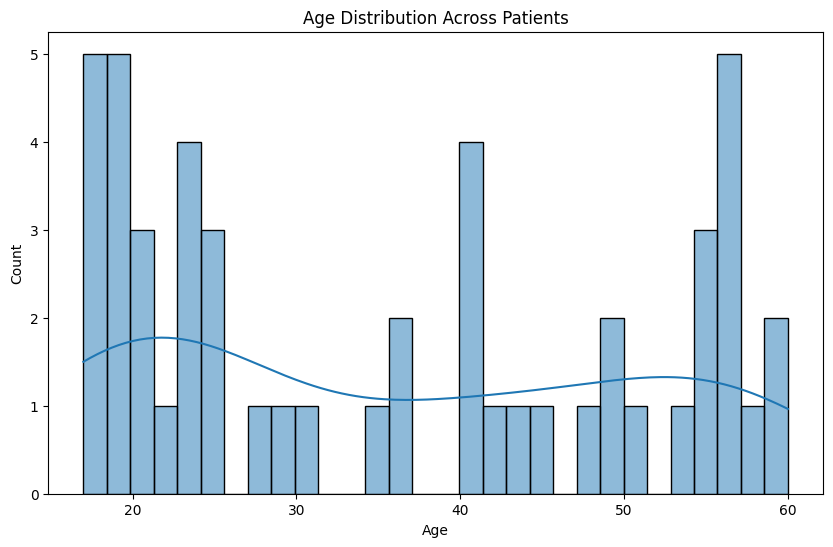

In [ ]:
# 1. Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_plot['age'], bins=30, kde=True)
plt.title('Age Distribution Across Patients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

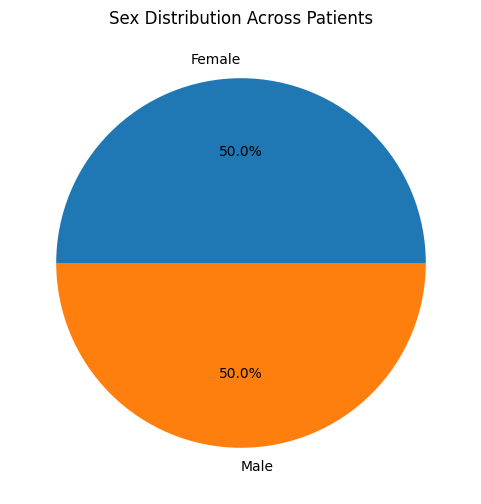

In [ ]:
# 2. Sex Distribution
plt.figure(figsize=(6, 6))
df_plot['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Sex Distribution Across Patients')
plt.ylabel('')
plt.show()

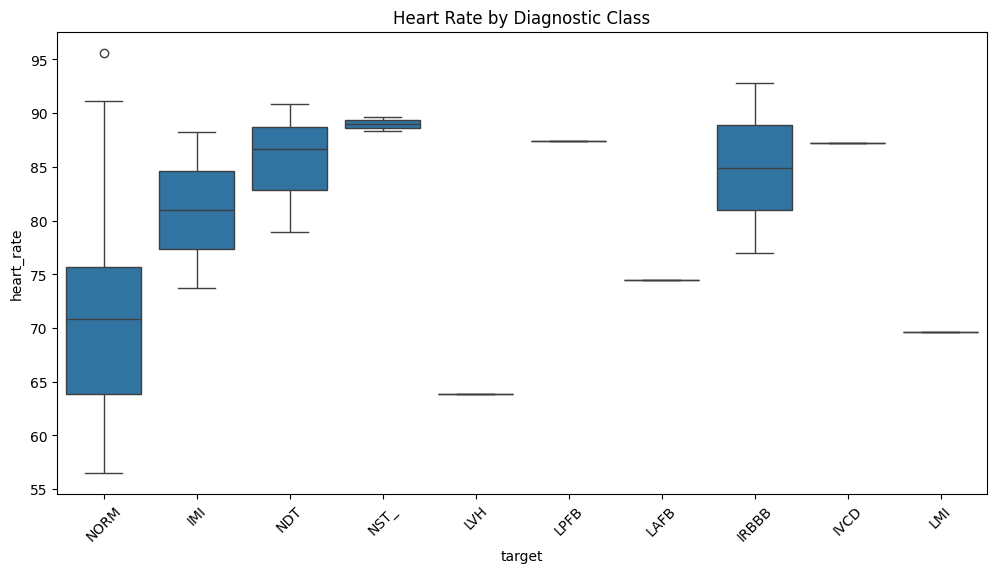

In [ ]:
# 3. Heart Rate by Target
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='heart_rate', data=df_plot)
plt.title('Heart Rate by Diagnostic Class')
plt.xticks(rotation=45)
plt.show()

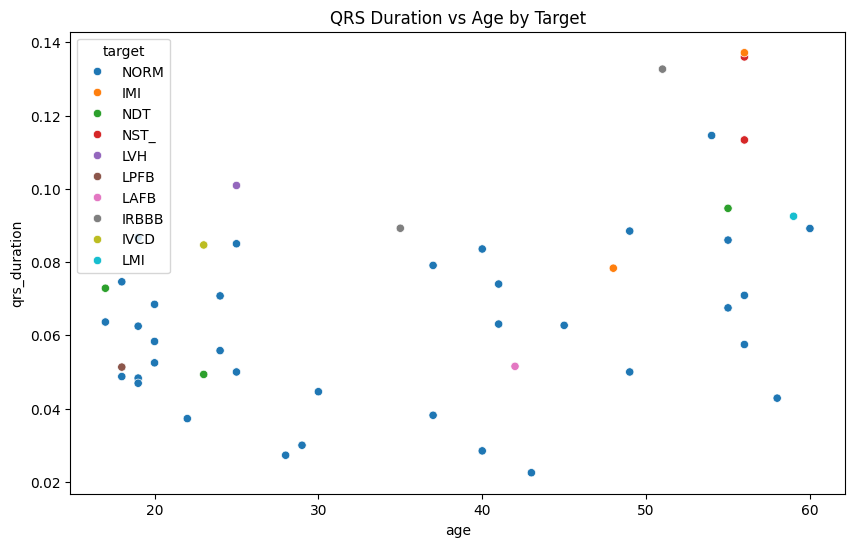

In [ ]:
# 4. QRS Duration vs Age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='qrs_duration', hue='target', data=df_plot)
plt.title('QRS Duration vs Age by Target')
plt.show()

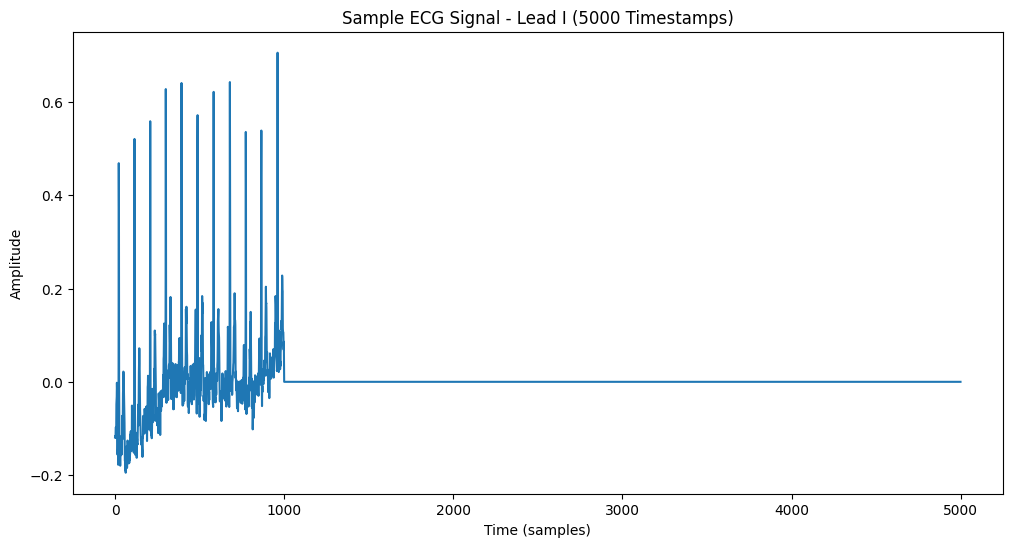

In [ ]:
# 5. Sample ECG Signal (Lead I)
plt.figure(figsize=(12, 6))
plt.plot(ecg_array[0, :, 0])
plt.title('Sample ECG Signal - Lead I (5000 Timestamps)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

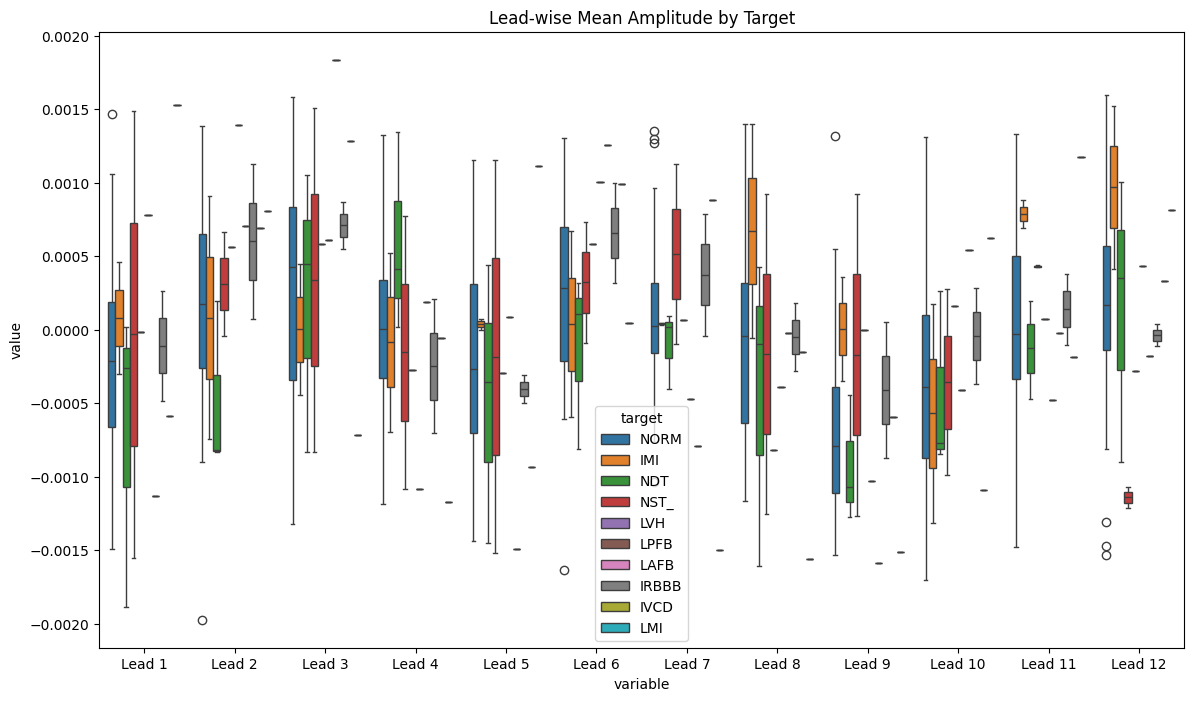

In [ ]:
# 6. Lead-wise Mean Amplitude by Target
lead_means_df = pd.DataFrame(np.mean(ecg_array, axis=1), columns=[f'Lead {i+1}' for i in range(12)])
lead_means_df['target'] = df_plot['target']
plt.figure(figsize=(14, 8))
sns.boxplot(data=lead_means_df.melt(id_vars='target'), x='variable', y='value', hue='target')
plt.title('Lead-wise Mean Amplitude by Target')
plt.show()

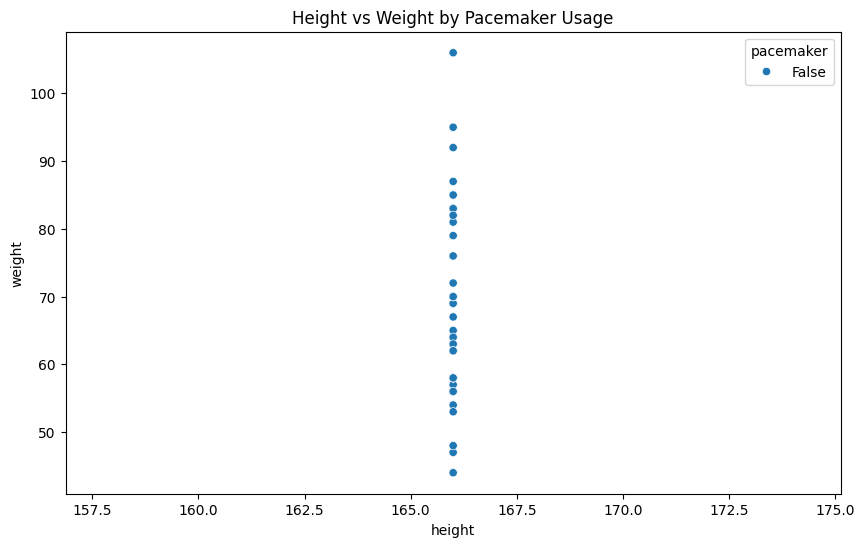

In [ ]:
# 8. Height vs Weight by Pacemaker
plt.figure(figsize=(10, 6))
sns.scatterplot(x='height', y='weight', hue='pacemaker', data=df_plot)
plt.title('Height vs Weight by Pacemaker Usage')
plt.show()

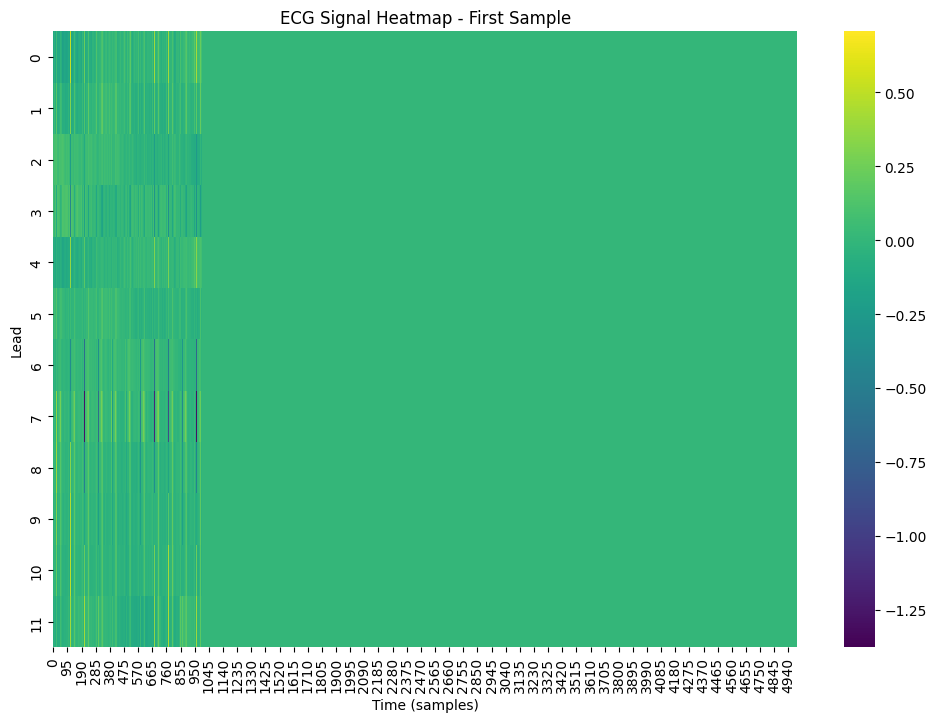

In [ ]:
# 9. ECG Heatmap (Sample)
plt.figure(figsize=(12, 8))
sns.heatmap(ecg_array[0, :, :].T, cmap='viridis')
plt.title('ECG Signal Heatmap - First Sample')
plt.xlabel('Time (samples)')
plt.ylabel('Lead')
plt.show()

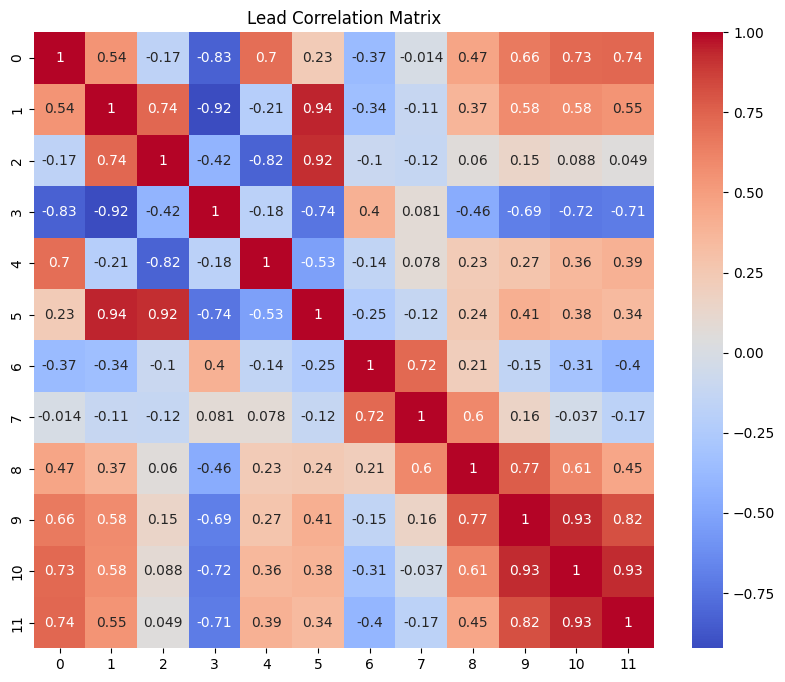

In [ ]:
# 10. Lead Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(np.corrcoef(ecg_array.reshape(-1, 12).T), annot=True, cmap='coolwarm')
plt.title('Lead Correlation Matrix')
plt.show()

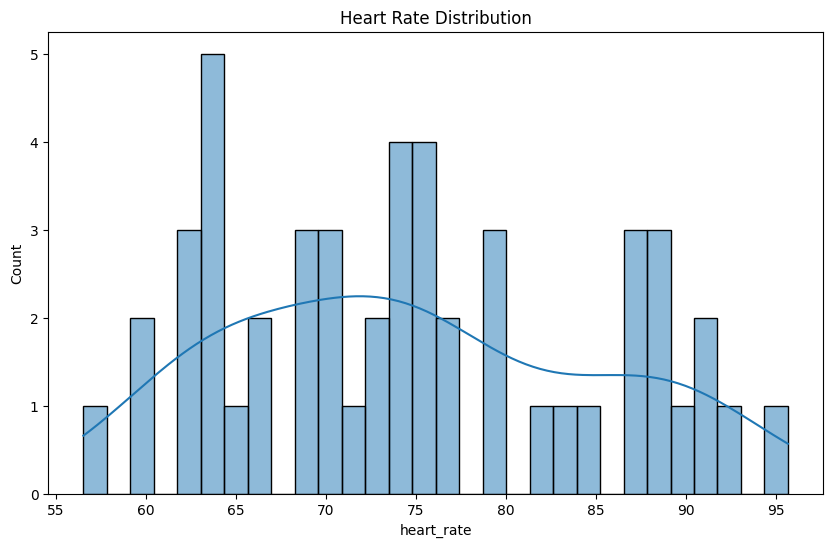

In [ ]:
# 11. Heart Rate Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_plot['heart_rate'], bins=30, kde=True)
plt.title('Heart Rate Distribution')
plt.show()

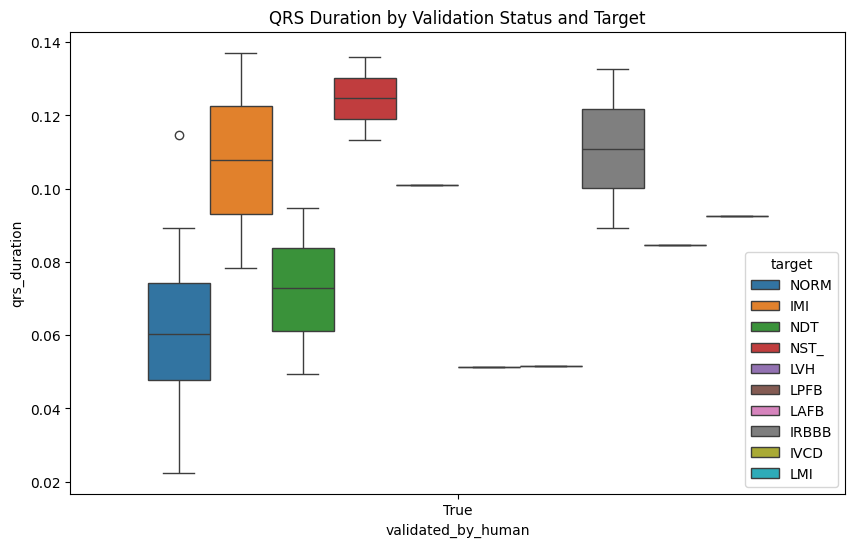

In [ ]:
# 12. QRS Duration by Validation Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='validated_by_human', y='qrs_duration', hue='target', data=df_plot)
plt.title('QRS Duration by Validation Status and Target')
plt.show()

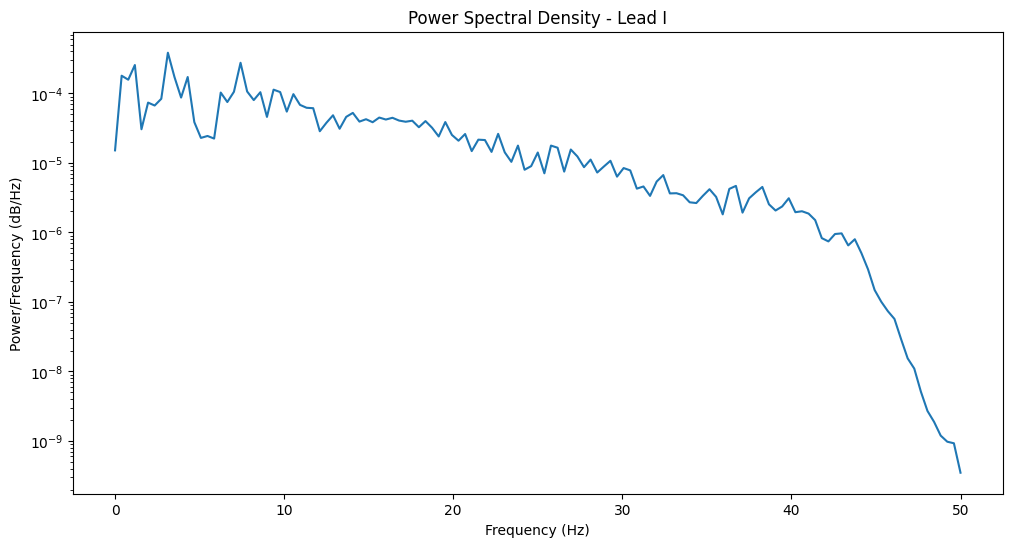

In [ ]:
# 13. Power Spectral Density (Lead I)
f, psd = welch(ecg_array[0, :, 0], fs=100, nperseg=256)
plt.figure(figsize=(12, 6))
plt.semilogy(f, psd)
plt.title('Power Spectral Density - Lead I')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()

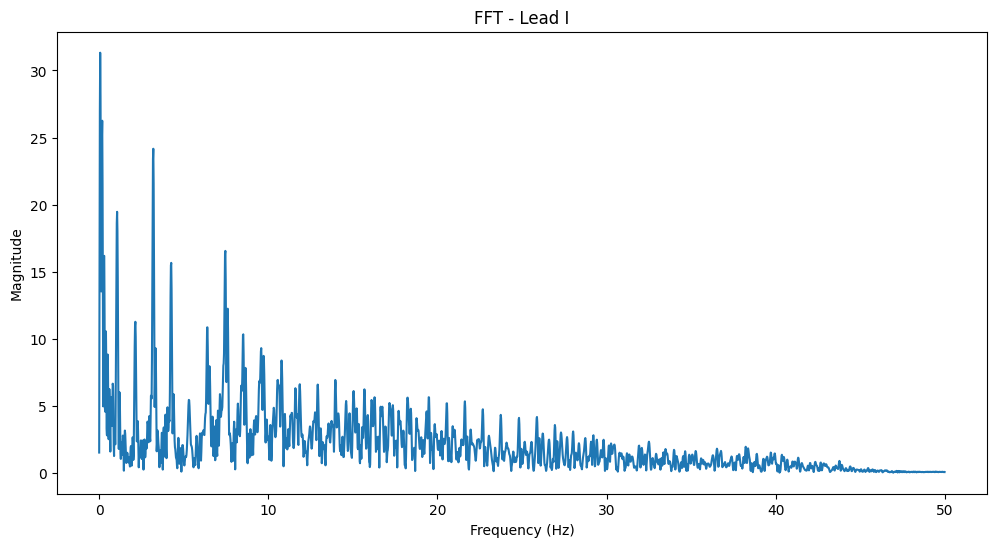

In [ ]:
# 14. FFT (Lead I)
fft_signal = fft(ecg_array[0, :, 0])
freq = np.fft.fftfreq(ecg_array.shape[1], d=1/100)
plt.figure(figsize=(12, 6))
plt.plot(freq[:len(freq)//2], np.abs(fft_signal)[:len(freq)//2])
plt.title('FFT - Lead I')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

<Figure size 1200x600 with 0 Axes>

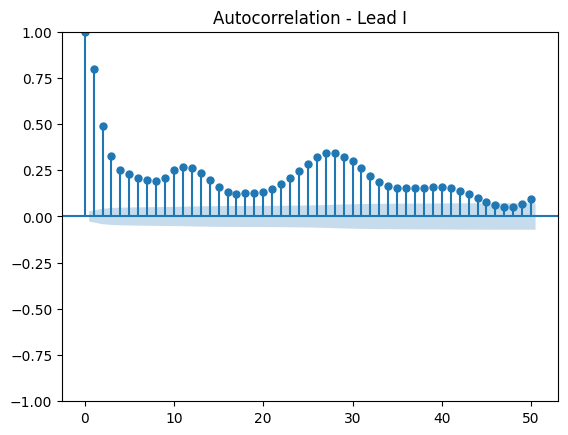

In [ ]:
# 15. Autocorrelation (Lead I)
plt.figure(figsize=(12, 6))
plot_acf(ecg_array[0, :, 0], lags=50)
plt.title('Autocorrelation - Lead I')
plt.show()

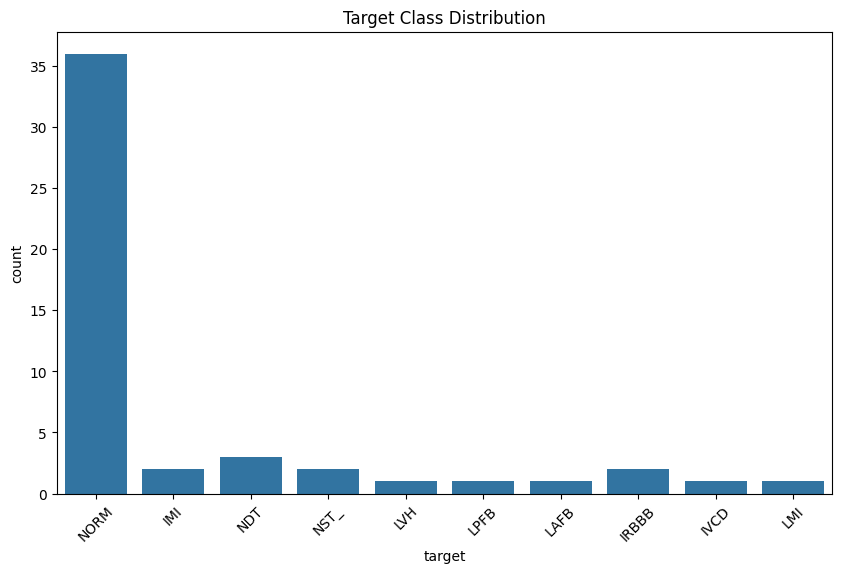

In [ ]:
# 16. Target Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df_plot)
plt.title('Target Class Distribution')
plt.xticks(rotation=45)
plt.show()

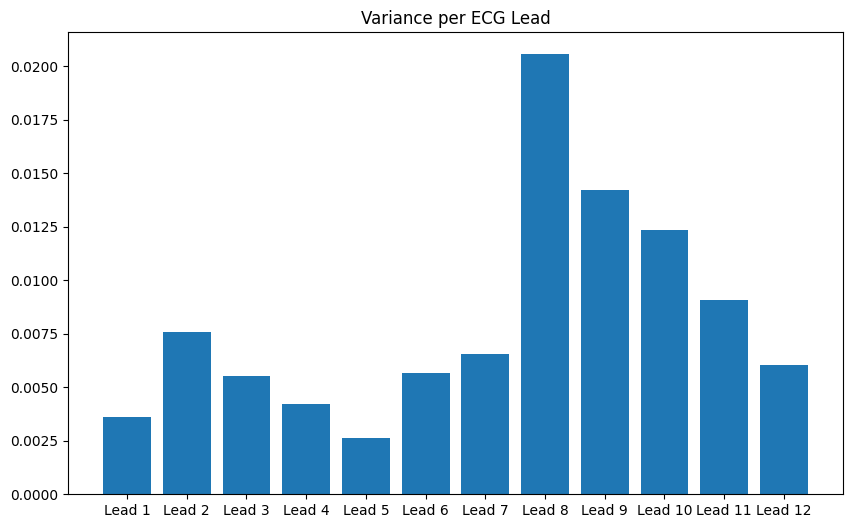

In [ ]:
# 17. Lead Variance
plt.figure(figsize=(10, 6))
plt.bar([f'Lead {i+1}' for i in range(12)], np.var(ecg_array, axis=(0, 1)))
plt.title('Variance per ECG Lead')
plt.show()

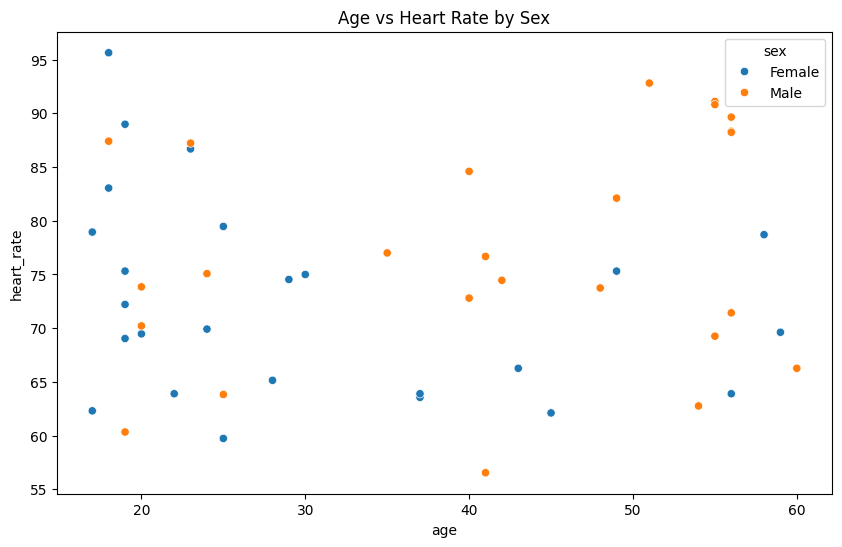

In [ ]:
# 19. Age vs Heart Rate by Sex
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='heart_rate', hue='sex', data=df_plot)
plt.title('Age vs Heart Rate by Sex')
plt.show()

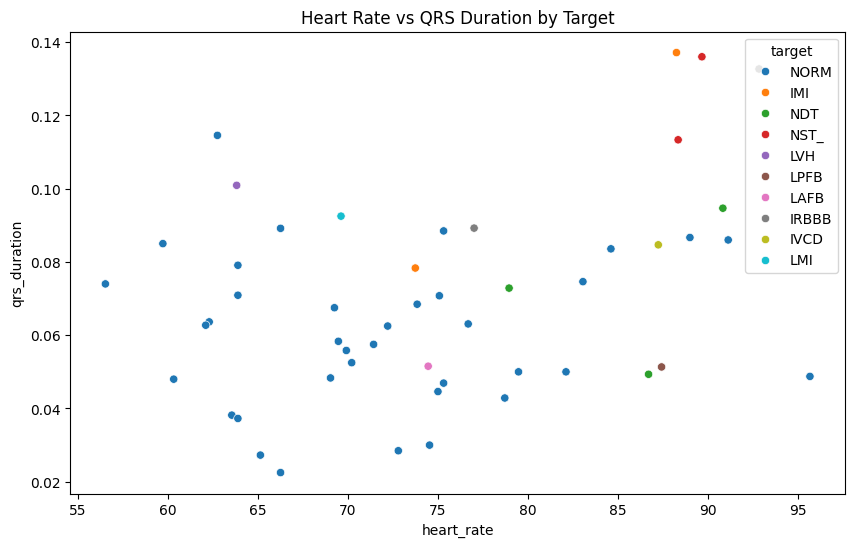

In [ ]:
# 20. Heart Rate vs QRS Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='heart_rate', y='qrs_duration', hue='target', data=df_plot)
plt.title('Heart Rate vs QRS Duration by Target')
plt.show()

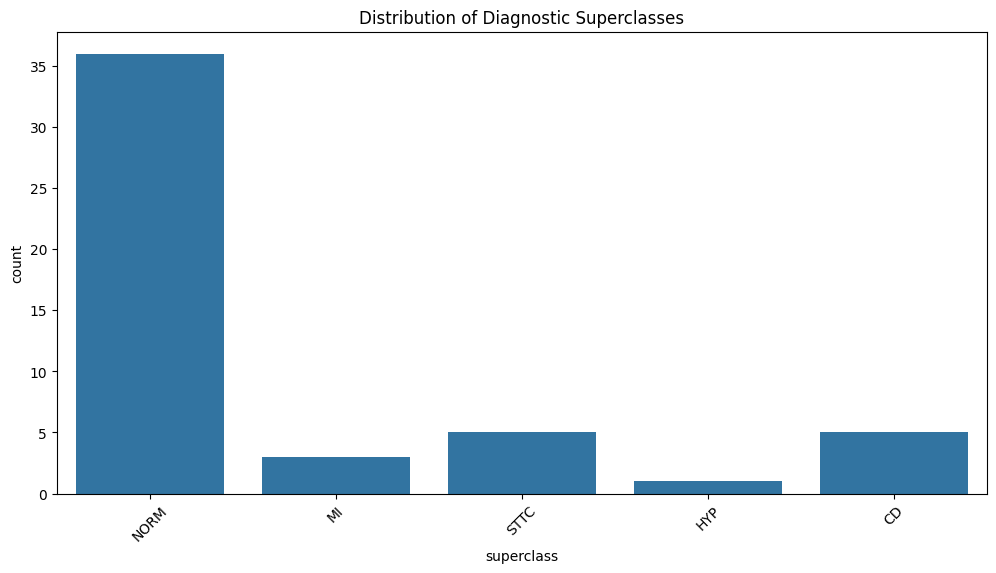

In [ ]:
# 21. Superclass Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='superclass', data=df_plot)
plt.title('Distribution of Diagnostic Superclasses')
plt.xticks(rotation=45)
plt.show()

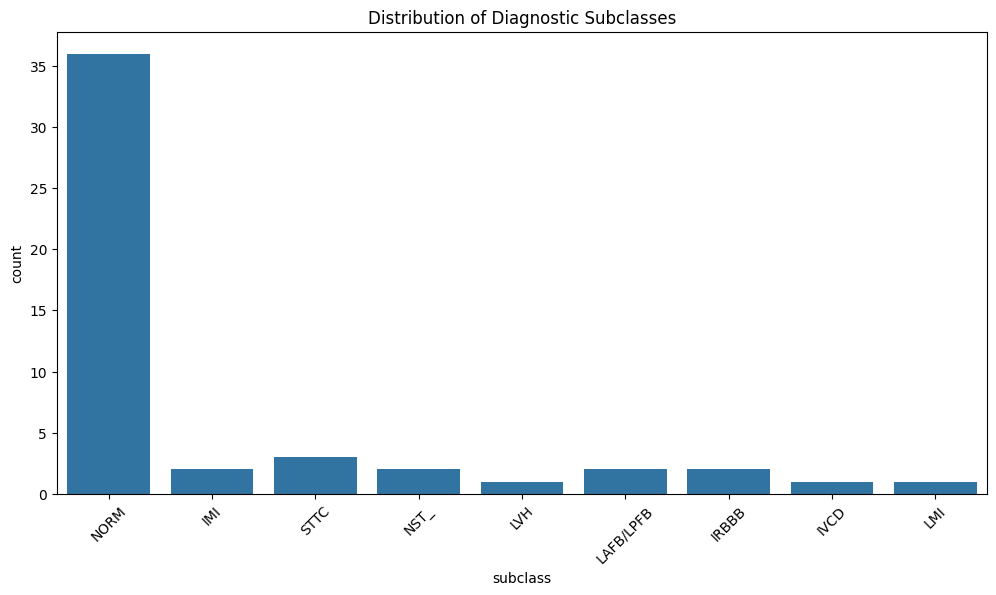

In [ ]:
# 22. Subclass Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='subclass', data=df_plot)
plt.title('Distribution of Diagnostic Subclasses')
plt.xticks(rotation=45)
plt.show()

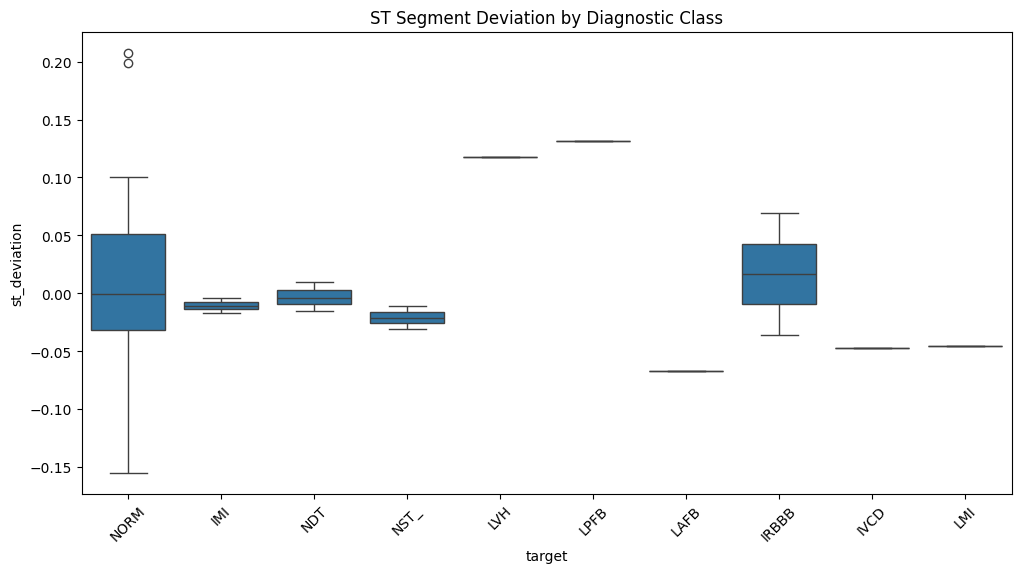

In [ ]:
# 23. ST Segment Deviation by Target
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='st_deviation', data=df_plot)
plt.title('ST Segment Deviation by Diagnostic Class')
plt.xticks(rotation=45)
plt.show()

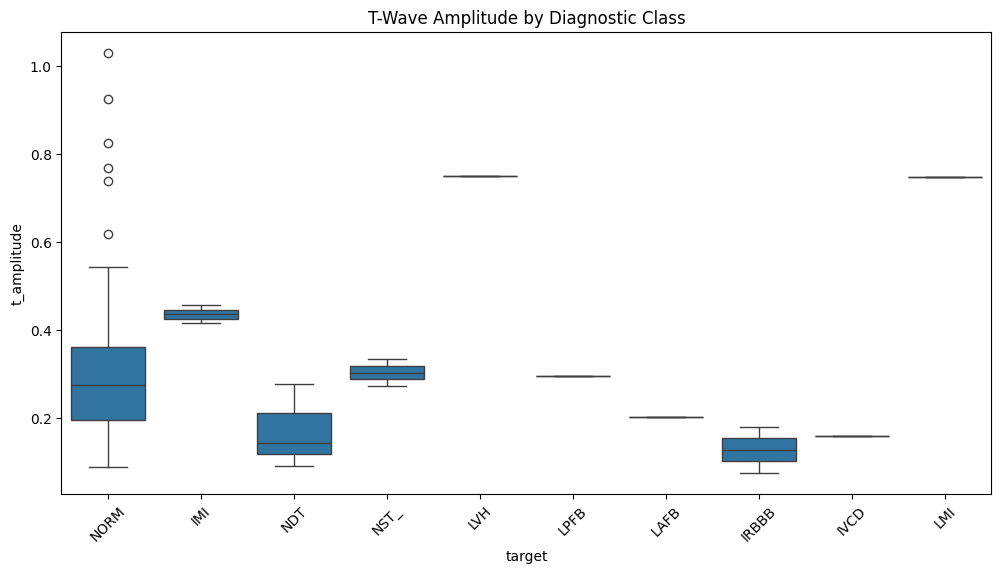

In [ ]:
# 24. T-Wave Amplitude by Target
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='t_amplitude', data=df_plot)
plt.title('T-Wave Amplitude by Diagnostic Class')
plt.xticks(rotation=45)
plt.show()

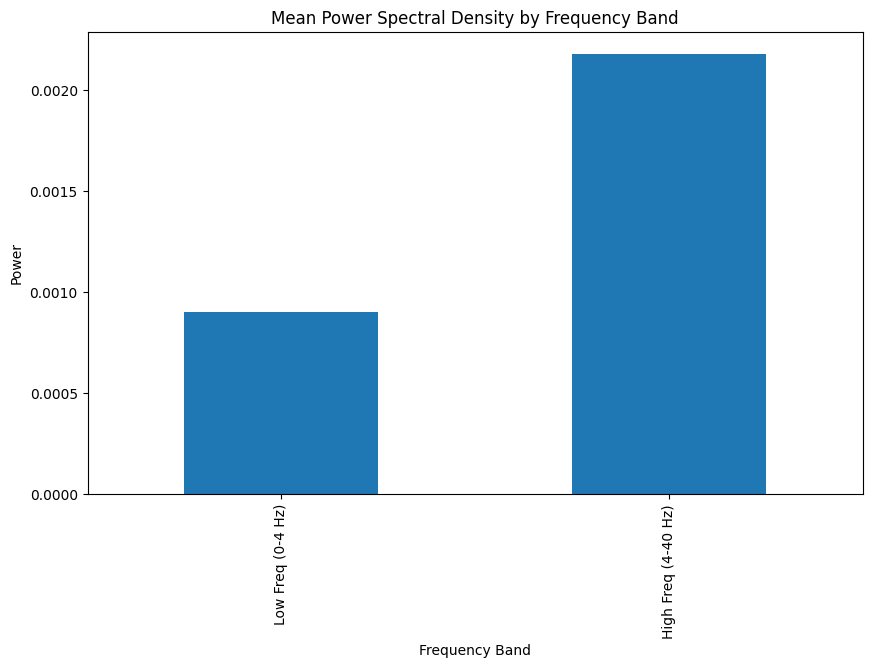

In [ ]:
# 25. PSD Power by Frequency Band
psd_data = pd.DataFrame({'Low Freq (0-4 Hz)': df_plot['low_freq_power'],
                         'High Freq (4-40 Hz)': df_plot['high_freq_power']})
plt.figure(figsize=(10, 6))
psd_data.mean().plot(kind='bar')
plt.title('Mean Power Spectral Density by Frequency Band')
plt.xlabel('Frequency Band')
plt.ylabel('Power')
plt.show()

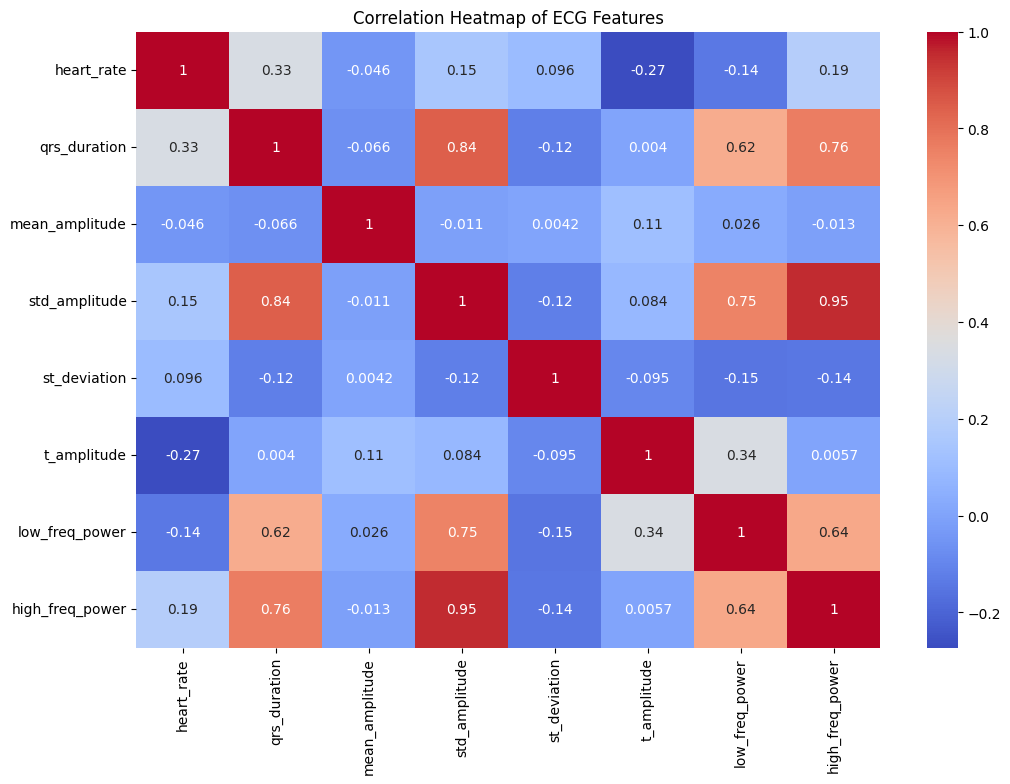

In [ ]:
# 26. ECG Feature Correlation Heatmap
feature_cols = ['heart_rate', 'qrs_duration', 'mean_amplitude', 'std_amplitude',
                'st_deviation', 't_amplitude', 'low_freq_power', 'high_freq_power']
plt.figure(figsize=(12, 8))
sns.heatmap(df_plot[feature_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of ECG Features')
plt.show()

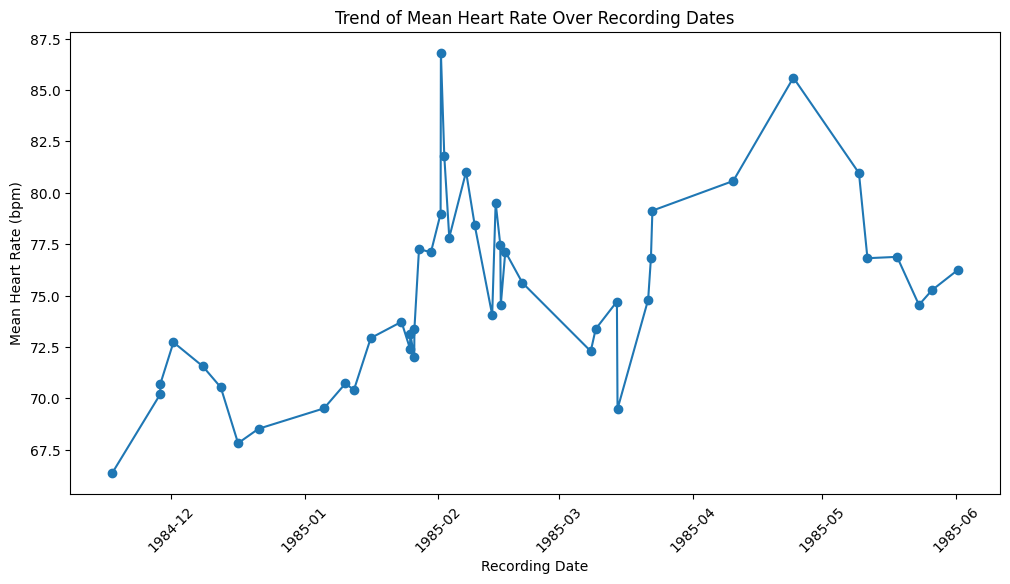

In [ ]:
# 27. Recording Date Trend
df_plot['recording_date'] = pd.to_datetime(df_plot['recording_date'])
df_plot = df_plot.sort_values('recording_date')
plt.figure(figsize=(12, 6))
plt.plot(df_plot['recording_date'], df_plot['heart_rate'].rolling(window=5).mean(), marker='o')
plt.title('Trend of Mean Heart Rate Over Recording Dates')
plt.xlabel('Recording Date')
plt.ylabel('Mean Heart Rate (bpm)')
plt.xticks(rotation=45)
plt.show()

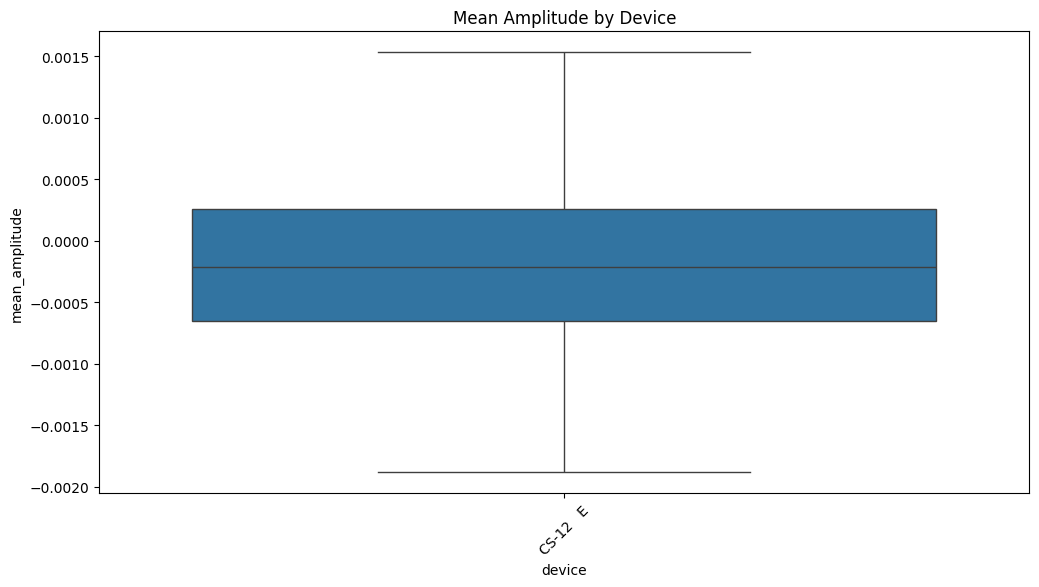

In [ ]:
# 28. Device vs. Mean Amplitude
plt.figure(figsize=(12, 6))
sns.boxplot(x='device', y='mean_amplitude', data=df_plot)
plt.title('Mean Amplitude by Device')
plt.xticks(rotation=45)
plt.show()

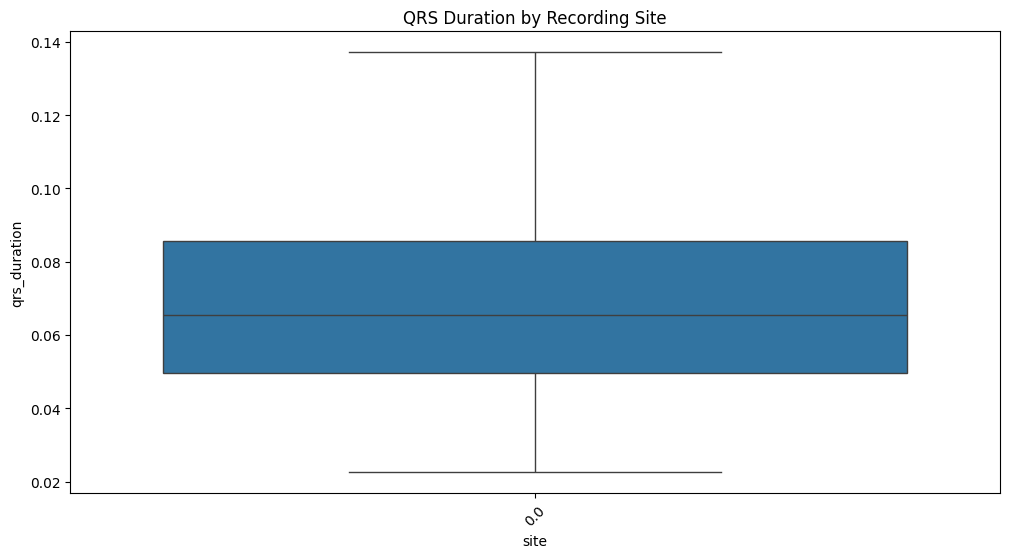

In [ ]:
# 29. Site vs. QRS Duration
plt.figure(figsize=(12, 6))
sns.boxplot(x='site', y='qrs_duration', data=df_plot)
plt.title('QRS Duration by Recording Site')
plt.xticks(rotation=45)
plt.show()

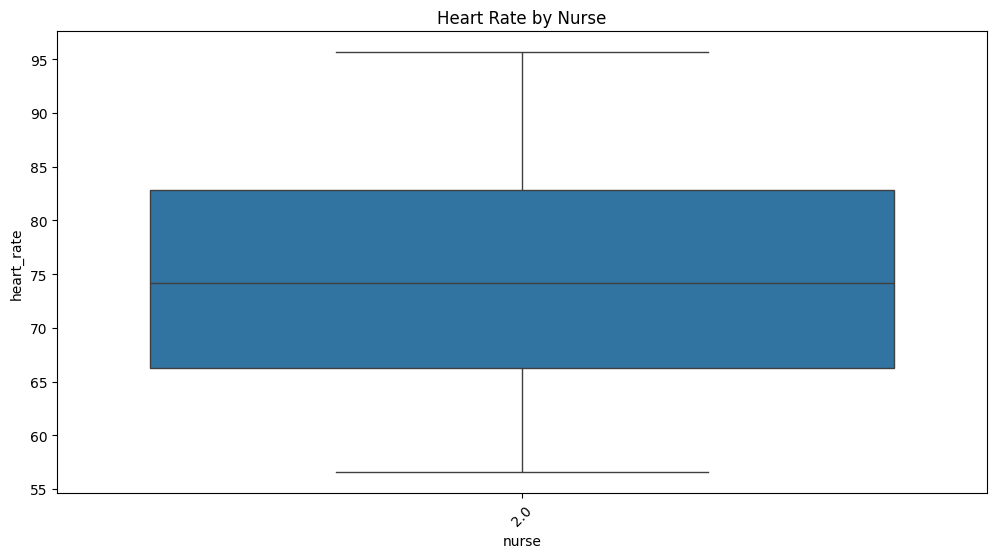

In [ ]:
# 30. Nurse vs. Heart Rate
plt.figure(figsize=(12, 6))
sns.boxplot(x='nurse', y='heart_rate', data=df_plot)
plt.title('Heart Rate by Nurse')
plt.xticks(rotation=45)
plt.show()

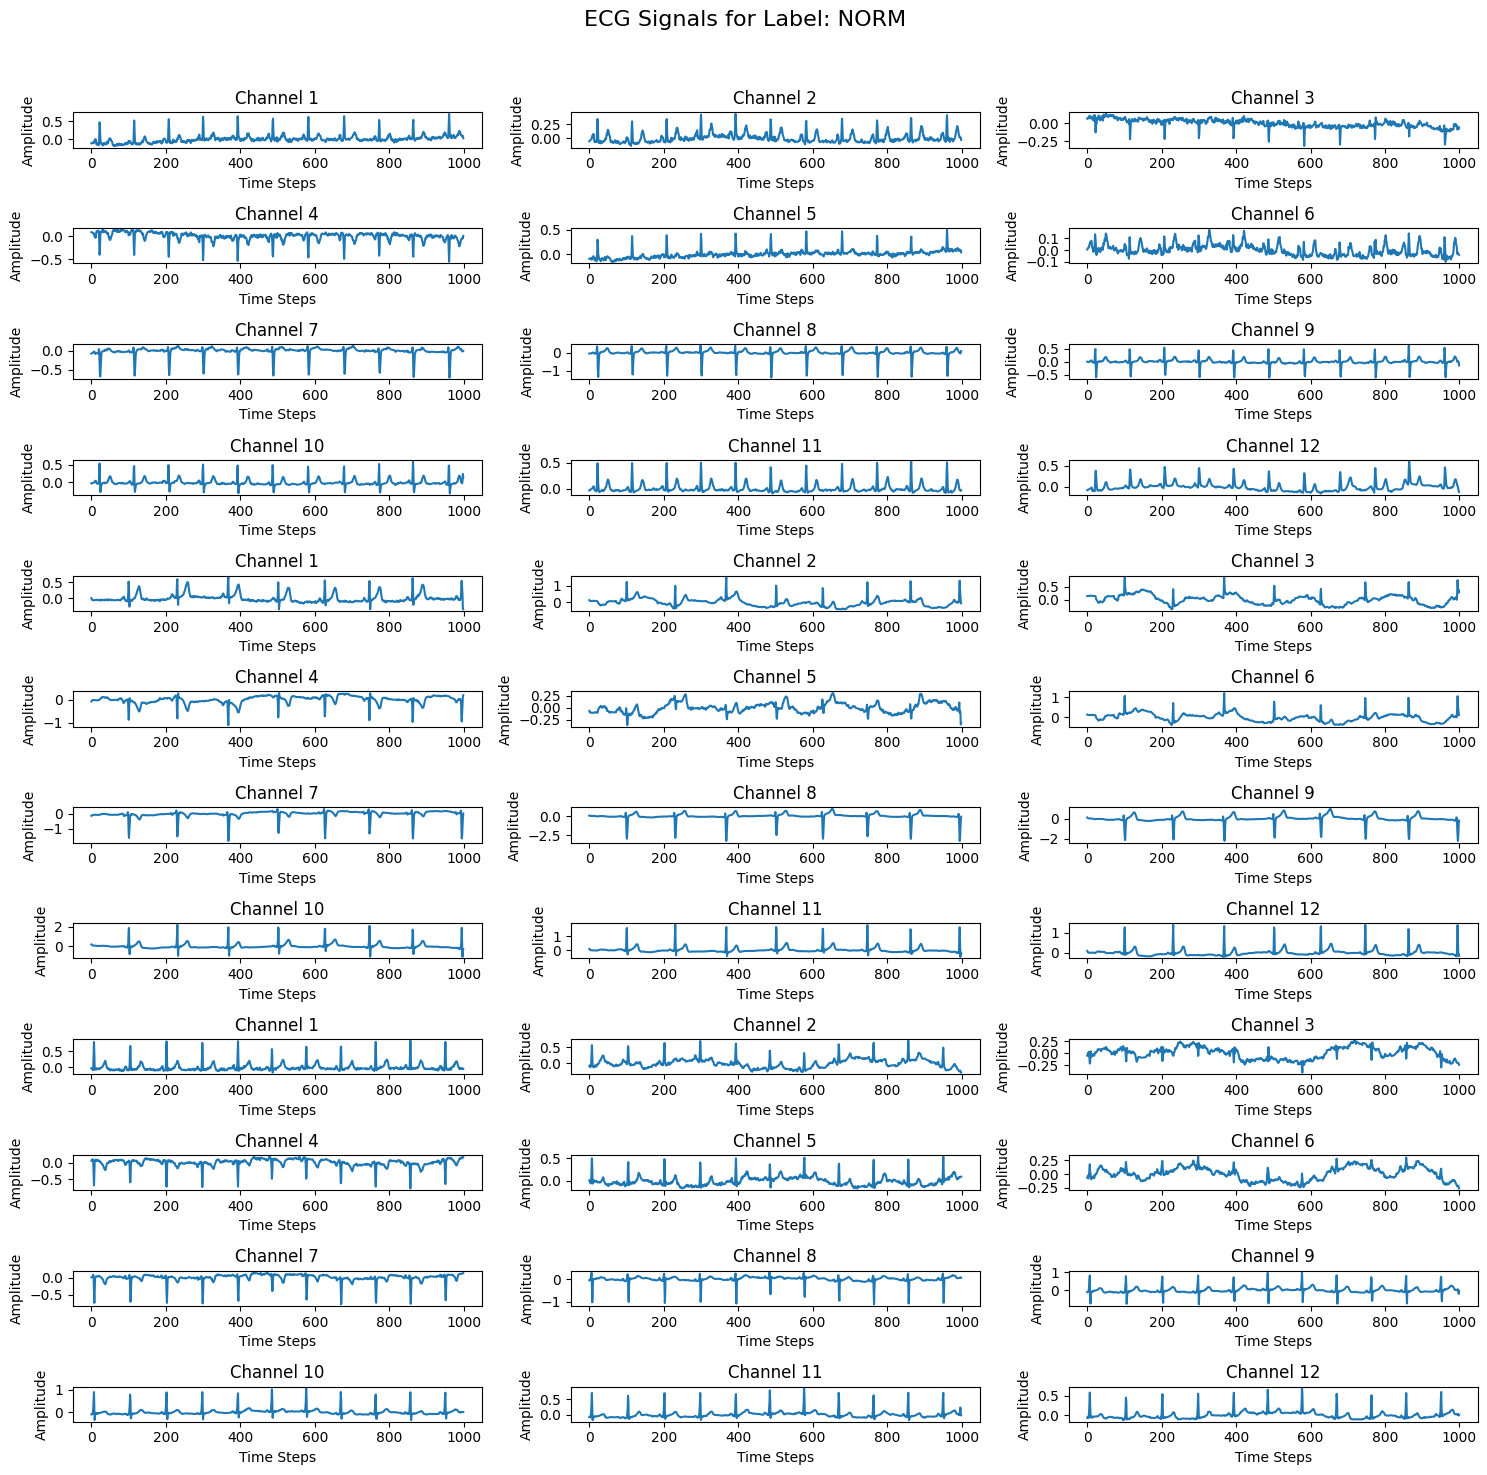

In [ ]:
# 31: Age KDE by Target

# Select indices for the "NORM" label
label_to_visualize = 'NORM'
indices = np.where(y == label_to_visualize)[0]

# Plot the first 3 samples for the "NORM" label
plt.figure(figsize=(15, 15))

for i, sample_idx in enumerate(indices[:3]):  # First 3 samples
    ecg_sample = ecg_data[sample_idx]  # Shape: (5000, 12) - Use ecg_data for ECG signals

    # Plot all 12 channels of the ECG signal
    for j in range(12):
        plt.subplot(12, 3, j + 1 + (i * 12))
        plt.plot(ecg_sample[:, j])  # Plot the j-th channel
        plt.title(f"Channel {j+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")

plt.suptitle(f"ECG Signals for Label: {label_to_visualize}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

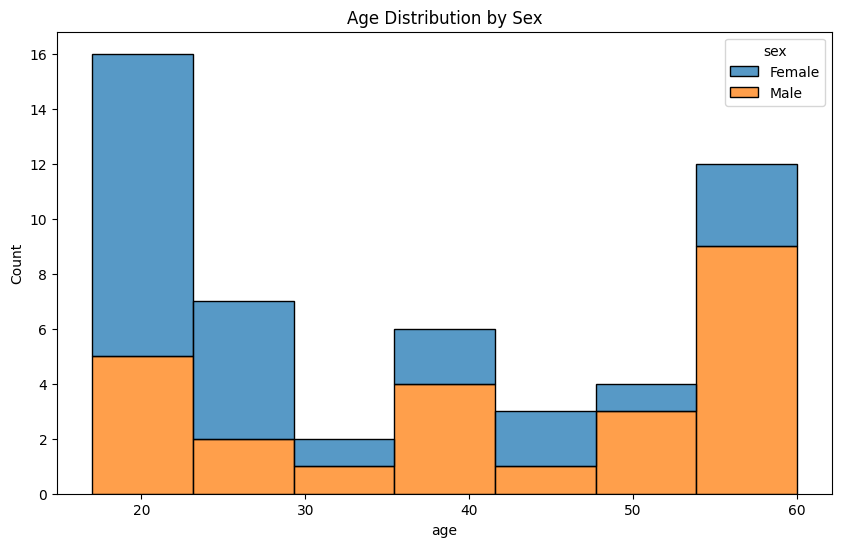

In [ ]:
# 32: Age by Sex
plt.figure(figsize=(10, 6))
sns.histplot(data=df_plot, x='age', hue='sex', multiple='stack')
plt.title('Age Distribution by Sex')
plt.show()

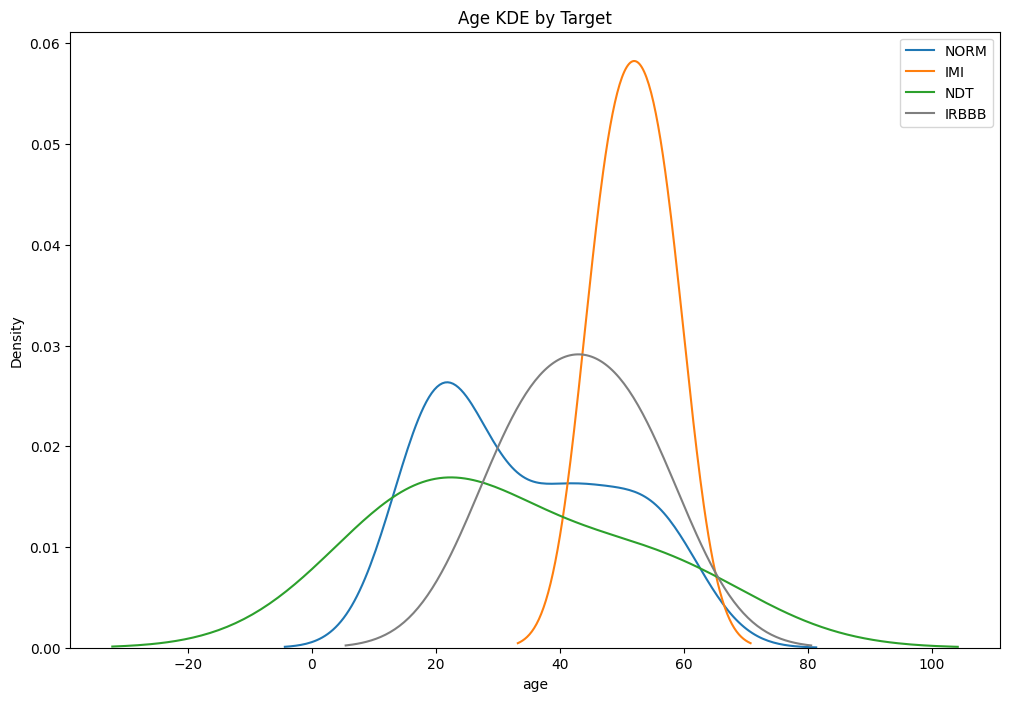

In [ ]:
# 33: Age KDE by Target
plt.figure(figsize=(12, 8))
for cls in df_plot['target'].unique():
    sns.kdeplot(df_plot[df_plot['target'] == cls]['age'], label=cls)
plt.title('Age KDE by Target')
plt.legend()
plt.show()

In [ ]:
X_demo.head()

,age,sex,height,weight,nurse,site,device,recording_date,validated_by,second_opinion,...,superclass,subclass,heart_rate,qrs_duration,mean_amplitude,std_amplitude,st_deviation,t_amplitude,low_freq_power,high_freq_power
0,56.0,Female,166.0,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,Unknown,False,...,NORM,NORM,63.897764,0.070909,0.000302,0.048760,0.053833,0.197,0.000567,0.001134
1,19.0,Male,166.0,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,Unknown,False,...,NORM,NORM,60.335196,0.048000,-0.000436,0.059677,-0.020350,0.739,0.002304,0.001463
2,37.0,Female,166.0,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,Unknown,False,...,NORM,NORM,63.559322,0.038182,-0.000554,0.054213,-0.024100,0.319,0.000827,0.001769
3,24.0,Male,166.0,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,Unknown,False,...,NORM,NORM,75.078206,0.070769,-0.000653,0.061641,0.198598,0.825,0.001342,0.002111
4,19.0,Female,166.0,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,Unknown,False,...,NORM,NORM,69.037657,0.048333,-0.000754,0.037018,0.050865,0.397,0.000435,0.000773


In [ ]:
X_demo[['age', 'sex'] + list(ecg_features_df.columns)].head()

,age,sex,heart_rate,qrs_duration,mean_amplitude,std_amplitude,st_deviation,t_amplitude,low_freq_power,high_freq_power
0,56.0,Female,63.897764,0.070909,0.000302,0.048760,0.053833,0.197,0.000567,0.001134
1,19.0,Male,60.335196,0.048000,-0.000436,0.059677,-0.020350,0.739,0.002304,0.001463
2,37.0,Female,63.559322,0.038182,-0.000554,0.054213,-0.024100,0.319,0.000827,0.001769
3,24.0,Male,75.078206,0.070769,-0.000653,0.061641,0.198598,0.825,0.001342,0.002111
4,19.0,Female,69.037657,0.048333,-0.000754,0.037018,0.050865,0.397,0.000435,0.000773


In [ ]:
# Select all features
features = X_demo.columns.tolist()
features.remove('target')  # Exclude target column
X = X_demo[features]

In [ ]:
# --- Preprocess Features ---
# Numerical columns
numerical_columns = ['age', 'height', 'weight', 'strat_fold'] + list(ecg_features_df.columns)

# Categorical columns (encode with one-hot encoding)
categorical_columns = ['sex', 'nurse', 'site', 'device', 'validated_by', 'infarction_stadium2', 'superclass', 'subclass']

# Boolean columns (convert to 0/1)
boolean_columns = ['second_opinion', 'initial_autogenerated_report', 'validated_by_human',
                   'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
                   'extra_beats', 'pacemaker']

# Exclude recording_date (datetime, not useful for modeling)
X = X.drop(columns=['recording_date'], errors='ignore')

# Encode categorical variables
for col in categorical_columns:
    if col in X.columns:
        X = pd.get_dummies(X, columns=[col], prefix=col, drop_first=True)

# Convert boolean columns to 0/1
for col in boolean_columns:
    if col in X.columns:
        X[col] = X[col].astype(int)

In [ ]:
# Handle missing values for numerical columns
X[numerical_columns] = X[numerical_columns].fillna(X[numerical_columns].median())

# Verify no missing values
if X.isna().sum().sum() > 0:
    raise ValueError(f"Missing values remain in columns: {X.columns[X.isna().any()].tolist()}")

In [ ]:
# --- Encode Target Labels ---
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(X_demo['target'])

In [ ]:
# --- Filter Classes with Sufficient Samples ---
class_counts = pd.Series(y).value_counts()
print("Class distribution before filtering:", class_counts)
valid_classes = class_counts[class_counts >= 2].index
mask = np.isin(y, valid_classes)
X = X[mask]
y = y[mask]
y = LabelEncoder().fit_transform(y)

Class distribution before filtering: 8    36
7     3
0     2
9     2
1     2
6     1
5     1
3     1
2     1
4     1
Name: count, dtype: int64
Class distribution after filtering: 3    36
2     3
0     2
4     2
1     2
Name: count, dtype: int64


In [ ]:
# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Standardize Numerical Features ---
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [ ]:
# --- Prepare Inputs for BiLSTM ---
ecg_feature_columns = list(ecg_features_df.columns)
demographic_columns = [col for col in X.columns if col not in ecg_feature_columns]

# Align ECG signals with train-test indices
train_indices = X_train.index.values
test_indices = X_test.index.values
ecg_train = ecg_array[train_indices].astype(np.float32)
ecg_test = ecg_array[test_indices].astype(np.float32)
demo_train = X_train[demographic_columns].values.astype(np.float32)
demo_test = X_test[demographic_columns].values.astype(np.float32)


In [ ]:
# Check for NaNs or Infs
for name, arr in [("ecg_train", ecg_train), ("demo_train", demo_train), ("ecg_test", ecg_test), ("demo_test", demo_test)]:
    if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
        raise ValueError(f"{name} contains NaN or Inf values")

# --- Define BiLSTM Model ---
number_of_demographic_features = len(demographic_columns)
number_of_classes = len(np.unique(y))

ecg_input = Input(shape=(5000, 12), name='ecg_input')
demo_input = Input(shape=(number_of_demographic_features,), name='demo_input')

x = Bidirectional(LSTM(64, return_sequences=False))(ecg_input)
x = Concatenate()([x, demo_input])
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(number_of_classes, activation='softmax')(x)

model = Model(inputs=[ecg_input, demo_input], outputs=output)


In [ ]:
# --- Compile Model ---
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Define ReduceLROnPlateau Callback ---
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# --- Train Model ---
print("\nTraining BiLSTM...")
history = model.fit([ecg_train, demo_train], y_train, epochs=50, batch_size=16,
                    validation_data=([ecg_test, demo_test], y_test), callbacks=[reduce_lr])

ecg_train shape: (36, 5000, 12) dtype: float32
demo_train shape: (36, 27) dtype: float32
y_train shape: (36,) dtype: int64
ecg_test shape: (9, 5000, 12) dtype: float32
demo_test shape: (9, 27) dtype: float32
y_test shape: (9,) dtype: int64

Training BiLSTM...
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4688 - loss: 1.4789 - val_accuracy: 0.6667 - val_loss: 1.4838 - learning_rate: 0.0010
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 916ms/step - accuracy: 0.8403 - loss: 1.3426 - val_accuracy: 0.6667 - val_loss: 1.4083 - learning_rate: 0.0010
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 486ms/step - accuracy: 0.8542 - loss: 1.2416 - val_accuracy: 0.6667 - val_loss: 1.3385 - learning_rate: 0.0010
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.8073 - loss: 1.1478 - val_accuracy: 0.6667 - val_loss: 1.2398 - learning_rate: 0.0010
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.8385 - loss: 0.9539 - val_accuracy: 0.6667 - val_loss: 1.1438 - learning_rate:

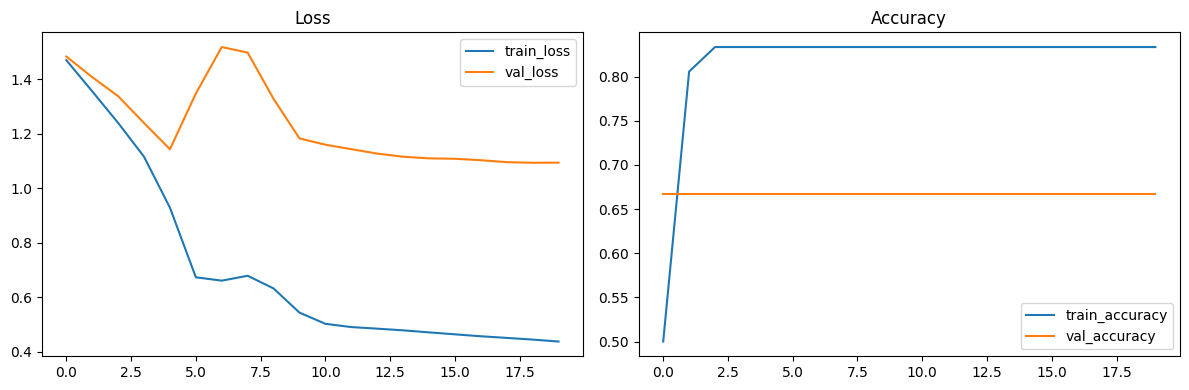

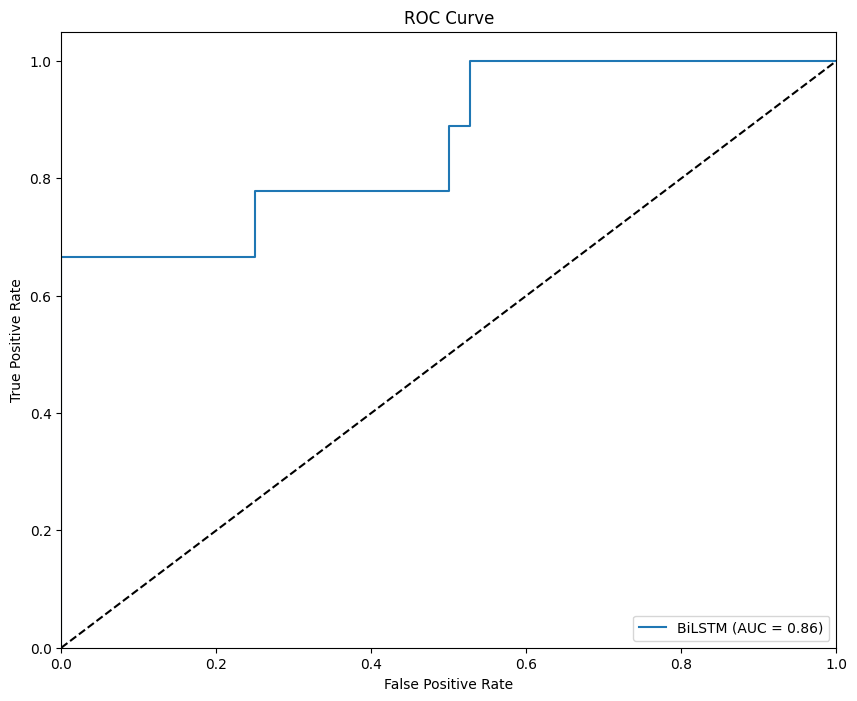

In [ ]:
# --- Initialize Metrics Storage ---
metrics = {'Accuracy': [], 'Recall': [], 'Precision': [], 'F1-Score': [], 'ROC-AUC': []}
y_probs = {}
model_names = ['BiLSTM']
classes = np.unique(y)

# --- Evaluate BiLSTM ---
print("\n--- BiLSTM ---")
y_prob = model.predict([ecg_test, demo_test])
y_pred = np.argmax(y_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(label_binarize(y_test, classes=classes), y_prob, multi_class='ovr')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_test, y_pred, zero_division=0))

metrics['Accuracy'].append(accuracy)
metrics['Recall'].append(recall)
metrics['Precision'].append(precision)
metrics['F1-Score'].append(f1)
metrics['ROC-AUC'].append(roc_auc)
y_probs['BiLSTM'] = y_prob

# --- Plot Training History ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()

# --- Plot ROC Curve ---
plt.figure(figsize=(10, 8))
for name in model_names:
    if y_probs[name] is not None:
        try:
            y_prob = y_probs[name]
            fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=classes).ravel(), y_prob.ravel())
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        except ValueError as e:
            print(f"ROC curve for {name} not plotted: {e}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve_bilstm.png')
plt.show()